<a href="https://colab.research.google.com/github/franciscogazaniga/TCC_Aprendizado_Maquina_Previsao_Energia_Fotovoltaica/blob/main/Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import

In [6]:
%%capture
!pip install kaleido
!pip install plotly>=4.0.0
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [7]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
import statsmodels.api as sm
import matplotlib.pyplot as plt # .pyplot é uma interface para o matplotlib que permite a geração de gráficos ao estilo MATLAB
import seaborn as sns # api para plotar gráficos
import plotly.express as px # api para plotar gráficos interativos
import plotly.graph_objects as go # para criar histogramas sobrepostos
import os # para salvar gráficos gerados pelo plotly

from statsmodels.stats.outliers_influence import variance_inflation_factor # para calcular VIF para análise de multicolinearidade
from sklearn.preprocessing import MinMaxScaler, StandardScaler # importa função para normalizar os dados
from sklearn.metrics import mean_squared_error # importa função para calcular MSE
from sklearn.compose import TransformedTargetRegressor # importa função para reverter normalização dos dados
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV # importa função para estratificar amostra (StratifiedShuffleSplit) e para testar diversos hiperparâmetros (GridSearchCV)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Flatten # para criar a camada de saída da rede neural
from keras.layers import LSTM # importa modelo LSTM
from keras.models import load_model # importa função para carregar modelos salvos
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # importa função para salvar o progresso dos modelos durante o treinamento e interromper o treinamento com antecedência, quando não houver mais progresso, importa também função para reduzir erro no gradiente
from openpyxl import Workbook, load_workbook # para manipular planilhas do excel
from matplotlib.cbook import local_over_kwdict

# 1.1 Ambiente

In [8]:
plt.style.use('seaborn-talk')

if not os.path.exists("images"):
    os.mkdir("images")

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(42)
   tf.random.set_seed(42)
   np.random.seed(42)

# Definir seu diretório aqui
diretorioDados = '/content/drive/MyDrive/TCC/Banco de Dados'
diretorioImagens = '/content/drive/MyDrive/TCC/Imagens'
diretorioModelos = '/content/drive/MyDrive/TCC/Modelos'    

# 2. Carregamento dos dados tratados

In [9]:
# Dados tratados
dtTratada = pd.read_csv(diretorioDados + '/planilha_tratada_completa_2.csv')

# Dados tradados normalizados
#dtTratadaNormalizada = pd.read_csv(diretorioDados + '/planilha_tratada_normalizada_completa.csv')

In [10]:
# Convertendo a coluna de data para o tipo 'datetime'
dtTratada['DATE_TIME'] = pd.to_datetime(dtTratada['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
#dtTratadaNormalizada['DATE_TIME'] = pd.to_datetime(dtTratadaNormalizada['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

In [11]:
dtGeracaoEnergia = dtTratada.copy()
dtGeracaoEnergia = dtGeracaoEnergia.drop(["Unnamed: 0"], axis = 1)
dtGeracaoEnergia

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,HOUR,AC_POWER,AC_POWER_FUTURO
0,2020-05-15 06:00:00,81aHJ1q11NBPMrL,24.742787,24.077230,0.012962,15,6,14.246667,14.840000
1,2020-05-15 06:00:00,9kRcWv60rDACzjR,24.742787,24.077230,0.012962,15,6,14.840000,15.020000
2,2020-05-15 06:00:00,LYwnQax7tkwH5Cb,24.742787,24.077230,0.012962,15,6,15.020000,14.673333
3,2020-05-15 06:00:00,LlT2YUhhzqhg5Sw,24.742787,24.077230,0.012962,15,6,14.673333,13.993333
4,2020-05-15 06:00:00,PeE6FRyGXUgsRhN,24.742787,24.077230,0.012962,15,6,13.993333,14.680000
...,...,...,...,...,...,...,...,...,...
21162,2020-06-17 17:45:00,WcxssY2VbP4hApt,26.091664,27.235657,0.065480,17,17,97.046667,96.620000
21163,2020-06-17 17:45:00,oZZkBaNadn6DNKz,26.091664,27.235657,0.065480,17,17,96.620000,94.700000
21164,2020-06-17 17:45:00,q49J1IKaHRwDQnt,26.091664,27.235657,0.065480,17,17,94.700000,89.680000
21165,2020-06-17 17:45:00,rrq4fwE8jgrTyWY,26.091664,27.235657,0.065480,17,17,89.680000,96.693333


## 2.1 Divisão da amostra

In [12]:
# Dividindo amostra de teste (20,63%) e treino/validação (79,37%)
filtro_teste =  ((dtGeracaoEnergia['DATE_TIME'].dt.month == 6) & (dtGeracaoEnergia['DATE_TIME'].dt.day > 10))
filtro_treino = (dtGeracaoEnergia['DATE_TIME'].dt.month == 5) | ((dtGeracaoEnergia['DATE_TIME'].dt.month == 6) & (dtGeracaoEnergia['DATE_TIME'].dt.day < 11))

teste = dtGeracaoEnergia[filtro_teste]
treino = dtGeracaoEnergia[filtro_treino]

In [13]:
treino

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,HOUR,AC_POWER,AC_POWER_FUTURO
0,2020-05-15 06:00:00,81aHJ1q11NBPMrL,24.742787,24.077230,0.012962,15,6,14.246667,14.840000
1,2020-05-15 06:00:00,9kRcWv60rDACzjR,24.742787,24.077230,0.012962,15,6,14.840000,15.020000
2,2020-05-15 06:00:00,LYwnQax7tkwH5Cb,24.742787,24.077230,0.012962,15,6,15.020000,14.673333
3,2020-05-15 06:00:00,LlT2YUhhzqhg5Sw,24.742787,24.077230,0.012962,15,6,14.673333,13.993333
4,2020-05-15 06:00:00,PeE6FRyGXUgsRhN,24.742787,24.077230,0.012962,15,6,13.993333,14.680000
...,...,...,...,...,...,...,...,...,...
17467,2020-06-10 17:45:00,oZZkBaNadn6DNKz,27.759774,25.464606,0.007683,10,17,13.207143,14.257143
17468,2020-06-10 17:45:00,q49J1IKaHRwDQnt,27.759774,25.464606,0.007683,10,17,14.257143,13.600000
17469,2020-06-10 17:45:00,rrq4fwE8jgrTyWY,27.759774,25.464606,0.007683,10,17,13.600000,14.471429
17470,2020-06-10 17:45:00,vOuJvMaM2sgwLmb,27.759774,25.464606,0.007683,10,17,14.471429,13.557143


In [14]:
teste

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,HOUR,AC_POWER,AC_POWER_FUTURO
2592,2020-06-11 06:00:00,81aHJ1q11NBPMrL,24.265365,23.726226,0.004264,11,6,0.700000,0.685714
2593,2020-06-11 06:00:00,9kRcWv60rDACzjR,24.265365,23.726226,0.004264,11,6,0.685714,0.614286
2594,2020-06-11 06:00:00,LYwnQax7tkwH5Cb,24.265365,23.726226,0.004264,11,6,0.614286,0.000000
2595,2020-06-11 06:00:00,LlT2YUhhzqhg5Sw,24.265365,23.726226,0.004264,11,6,0.000000,0.573333
2596,2020-06-11 06:00:00,PeE6FRyGXUgsRhN,24.265365,23.726226,0.004264,11,6,0.573333,1.366667
...,...,...,...,...,...,...,...,...,...
21162,2020-06-17 17:45:00,WcxssY2VbP4hApt,26.091664,27.235657,0.065480,17,17,97.046667,96.620000
21163,2020-06-17 17:45:00,oZZkBaNadn6DNKz,26.091664,27.235657,0.065480,17,17,96.620000,94.700000
21164,2020-06-17 17:45:00,q49J1IKaHRwDQnt,26.091664,27.235657,0.065480,17,17,94.700000,89.680000
21165,2020-06-17 17:45:00,rrq4fwE8jgrTyWY,26.091664,27.235657,0.065480,17,17,89.680000,96.693333


In [15]:
dtGeracaoEnergia

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,HOUR,AC_POWER,AC_POWER_FUTURO
0,2020-05-15 06:00:00,81aHJ1q11NBPMrL,24.742787,24.077230,0.012962,15,6,14.246667,14.840000
1,2020-05-15 06:00:00,9kRcWv60rDACzjR,24.742787,24.077230,0.012962,15,6,14.840000,15.020000
2,2020-05-15 06:00:00,LYwnQax7tkwH5Cb,24.742787,24.077230,0.012962,15,6,15.020000,14.673333
3,2020-05-15 06:00:00,LlT2YUhhzqhg5Sw,24.742787,24.077230,0.012962,15,6,14.673333,13.993333
4,2020-05-15 06:00:00,PeE6FRyGXUgsRhN,24.742787,24.077230,0.012962,15,6,13.993333,14.680000
...,...,...,...,...,...,...,...,...,...
21162,2020-06-17 17:45:00,WcxssY2VbP4hApt,26.091664,27.235657,0.065480,17,17,97.046667,96.620000
21163,2020-06-17 17:45:00,oZZkBaNadn6DNKz,26.091664,27.235657,0.065480,17,17,96.620000,94.700000
21164,2020-06-17 17:45:00,q49J1IKaHRwDQnt,26.091664,27.235657,0.065480,17,17,94.700000,89.680000
21165,2020-06-17 17:45:00,rrq4fwE8jgrTyWY,26.091664,27.235657,0.065480,17,17,89.680000,96.693333


In [16]:
# Para treinar o modelo com múltiplos atributos de entrada descomentar o trecho de código abaixo e comentar o segundo trecho de código

# Entrada para o modelo com todos os atributos (Com exceção do atributo do Mês visto a baixa variância deste atributo no conjunto de dados)
# nomeEntrada = '_Multi'
# dataset_treino = treino[["AMBIENT_TEMPERATURE",	"MODULE_TEMPERATURE",	"IRRADIATION",	"DAY",	"HOUR", "AC_POWER", "AC_POWER_FUTURO"]].values
# dataset_teste = teste[["AMBIENT_TEMPERATURE",	"MODULE_TEMPERATURE",	"IRRADIATION",	"DAY",	"HOUR", "AC_POWER", "AC_POWER_FUTURO"]].values
# dataset_completo = dtGeracaoEnergia[["AMBIENT_TEMPERATURE",	"MODULE_TEMPERATURE",	"IRRADIATION",	"DAY",	"HOUR", "AC_POWER", "AC_POWER_FUTURO"]].values

#Entrada para o modelo com apenas o atributo de irradiação
nomeEntrada = ''
dataset_treino = treino[["IRRADIATION", "AC_POWER_FUTURO"]].values
dataset_teste = teste[["IRRADIATION", "AC_POWER_FUTURO"]].values
dataset_completo = dtGeracaoEnergia[["IRRADIATION", "AC_POWER_FUTURO"]].values

In [17]:
# Formato dos dados de treino
print(dataset_treino.shape)

# Formato dos dados de teste
print(dataset_teste.shape)

# Formato dos dados da amostra completa
print(dataset_completo.shape)

(16800, 2)
(4367, 2)
(21167, 2)


## 2.2 Normalizar amostras com dados de treino

In [18]:
# Normalizar o conjunto de teste com todo o conjunto de dados irá carregar informações da amostra completa para o conjunto de teste
scaler_com_dados_treino = MinMaxScaler(feature_range = (0, 1))
#scaler_com_dados_treino = StandardScaler()

# usando apenas o conjunto de treinamento
dataset_treino_normalizado = scaler_com_dados_treino.fit_transform(dataset_treino)

# no conjunto de treinamento para normalizar o conjunto de teste
dataset_teste_normalizado = scaler_com_dados_treino.transform(dataset_teste)

#  no conjunto de treinamento para normalizar o conjunto completo
dataset_completo_normalizado = scaler_com_dados_treino.transform(dataset_completo)

In [19]:
dataset_treino_normalizado

array([[0.01179685, 0.01076324],
       [0.01179685, 0.01089379],
       [0.01179685, 0.01064236],
       ...,
       [0.00699281, 0.01049592],
       [0.00699281, 0.0098328 ],
       [0.00699281, 0.06149457]])

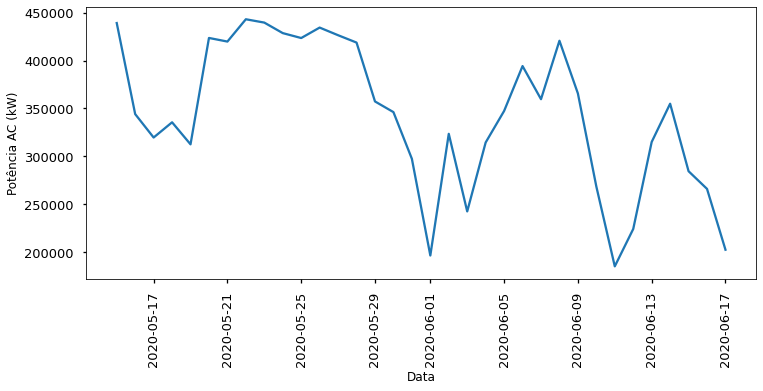

In [20]:
# Saída a ser prevista
dtGeracaoEnergiaPlot = dtTratada.copy() # Copia conteúdo da tabela de dados da planta
dtGeracaoEnergiaPlot['Data'] = dtGeracaoEnergiaPlot['DATE_TIME'].dt.date # Reune os dados de data somente
dtGeracaoEnergiaPlot = dtGeracaoEnergiaPlot.groupby('Data').sum() # Agrupa todos os dados para as 34 datas
dtGeracaoEnergiaPlot['AC_POWER'].plot(figsize=(12,5),label='Energia AC Gerada')

plt.ylabel('Potência AC (kW)',fontsize=12)
plt.xlabel('Data',fontsize=12)
plt.xticks(rotation = 90)
plt.savefig(diretorioImagens + '/potencia_ac_gerada.png', format='png', bbox_inches='tight')
plt.show()

## 2.3 Relação entrada e saída

In [21]:
entradaX = dataset_teste_normalizado[:,:-1]
saidaY = dataset_teste_normalizado[:,-1].reshape(-1,1)

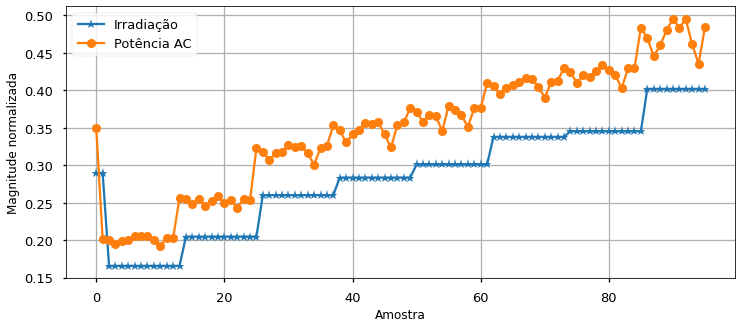

In [22]:
# Relação de entrada vs saída
i=790
j=i+48*2
plt.figure(figsize=(12,5))
plt.plot(range(j-i), entradaX[i:j],'-*' ,range(j-i), saidaY[i:j],'-o')
plt.legend(('Irradiação','Potência AC'))
plt.xlabel('Amostra',fontsize=12)
plt.ylabel('Magnitude normalizada',fontsize=12)
plt.savefig(diretorioImagens + '/Entrada_vs_Saida' + '.png', format='png', bbox_inches='tight')
plt.grid()
plt.show()

# 3. Modelagem com RL

In [23]:
treinoX = dataset_treino_normalizado[:,:-1]
treinoY = dataset_treino_normalizado[:,-1].reshape(-1,1)

testeX = dataset_teste_normalizado[:,:-1]
testeY = dataset_teste_normalizado[:,-1].reshape(-1,1)

completoX = dataset_completo_normalizado[:,:-1]
completoY = dataset_completo_normalizado[:,-1].reshape(-1,1)

In [24]:
treinoX

array([[0.01179685],
       [0.01179685],
       [0.01179685],
       ...,
       [0.00699281],
       [0.00699281],
       [0.00699281]])

In [25]:
treinoY

array([[0.01076324],
       [0.01089379],
       [0.01064236],
       ...,
       [0.01049592],
       [0.0098328 ],
       [0.06149457]])

In [26]:
# Formato dos dados previstos para teste
print(testeX.shape, testeY.shape)

# Formato dos dados previstos para treino
print(treinoX.shape, treinoY.shape)

# Formato dos dados previstos para a amostra completa
print(completoX.shape, completoY.shape)

(4367, 1) (4367, 1)
(16800, 1) (16800, 1)
(21167, 1) (21167, 1)


In [27]:
# Treinamento do modelo linear simples
nomeModelo = 'RL_'

model_RL_multi = LinearRegression().fit(treinoX, treinoY)

# Previsão da amostra de teste - LSTM
previsaoTesteNormalizado = model_RL_multi.predict(testeX)

# Previsão da amostra de treino - LSTM
previsaoTreinoNormalizado = model_RL_multi.predict(treinoX)

# Previsão da amostra completa - LSTM
previsaoCompletoNormalizado = model_RL_multi.predict(completoX)

## 3.1 Erro MSE

In [28]:
#Erro quadrático médio (MSE)
desempenho_treino = mean_squared_error(treinoY, previsaoTreinoNormalizado)
print(f'Desempenho do treinamento: {desempenho_treino} MSE')

desempenho_teste = mean_squared_error(testeY, previsaoTesteNormalizado)
print(f'Desempenho do teste: {desempenho_teste} MSE')

desempenho_completo = mean_squared_error(completoY, previsaoCompletoNormalizado)
print(f'Desempenho da amostra completa: {desempenho_completo} MSE')
print(f'Hipótese Linear: y_hat = {model_RL_multi.intercept_} + {model_RL_multi.coef_[0]} x')

Desempenho do treinamento: 0.011703844483349584 MSE
Desempenho do teste: 0.007825367447687437 MSE
Desempenho da amostra completa: 0.010903669247617709 MSE
Hipótese Linear: y_hat = [0.02329712] + [0.95676469] x


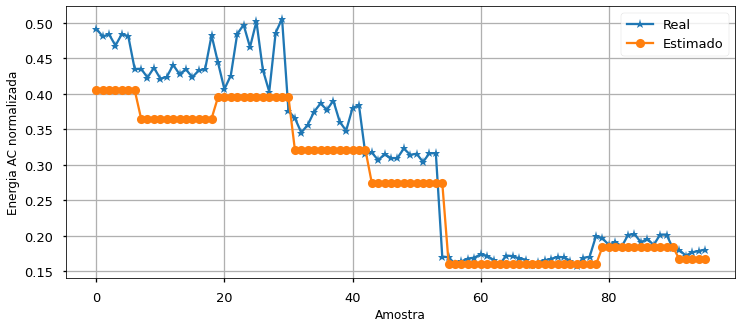

In [29]:
# Desempenho no teste
i=1589
j=i+48*2
plt.figure(figsize=(12,5))
plt.plot(range(j-i), testeY[i:j],'-*' ,range(j-i), previsaoTesteNormalizado[i:j],'-o')
plt.legend(('Real','Estimado'))
plt.xlabel('Amostra',fontsize=12)
plt.ylabel('Energia AC normalizada',fontsize=12)
plt.savefig(diretorioImagens + '/Desempenho_Teste_' + nomeModelo + '.png', format='png', bbox_inches='tight')
plt.grid()
plt.show()

## 3.2 Invertendo Normalização

In [30]:
# Imprime valores minímos e máximos
# min_ = min - X.min(axis=0) * self.scale_
# scale_ = (max - min) / (X.max(axis=0) - X.min(axis=0))
# data_min_ = valor mínimo na amostra
# data_max_ = valor máximo na amostra
scaler_com_dados_treino.min_, scaler_com_dados_treino.scale_, scaler_com_dados_treino.data_min_, scaler_com_dados_treino.data_max_

(array([0., 0.]),
 array([9.10111853e-01, 7.25285884e-04]),
 array([0., 0.]),
 array([1.09876604e+00, 1.37876667e+03]))

In [31]:
# Invertendo normalização para interpretação dos resultados
scale = MinMaxScaler()
scale.min_, scale.scale_ = scaler_com_dados_treino.min_[treinoX.shape[1]], scaler_com_dados_treino.scale_[treinoX.shape[1]]

# Para amostra de teste
previsaoTesteNormalizadoInvertido_RL = scale.inverse_transform(previsaoTesteNormalizado) # Inverte normalização para os valores previstos de teste

# Para amostra de treino
previsaoTreinoNormalizadoInvertido_RL = scale.inverse_transform(previsaoTreinoNormalizado)

# Para amostra completa
previsaoCompletoNormalizadoInvertido_RL = scale.inverse_transform(previsaoCompletoNormalizado)

# Para amostra real teste
testeY_invertido =  scale.inverse_transform(testeY.reshape(-1,1))

# Para amostra real teste
treinoY_invertido =  scale.inverse_transform(treinoY.reshape(-1,1))

# Para amostra real teste
completoY_invertido =  scale.inverse_transform(completoY.reshape(-1,1))

## 3.3 Resultado das Previsões

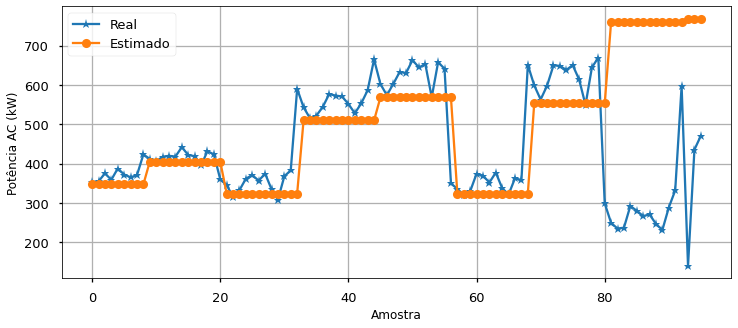

In [32]:
i=1779
j=i+48*2
plt.figure(figsize=(12,5))
plt.plot(range(j-i), np.array(teste['AC_POWER_FUTURO'][i:j]),'-*' ,range(j-i), previsaoTesteNormalizadoInvertido_RL[i:j],'-o')
plt.legend(('Real','Estimado'))
plt.xlabel('Amostra',fontsize=12)
plt.ylabel('Potência AC (kW)',fontsize=12)
plt.savefig(diretorioImagens + '/Desempenho_Teste_Invertido' + nomeModelo + '.png', format='png', bbox_inches='tight')
plt.grid()
plt.show()

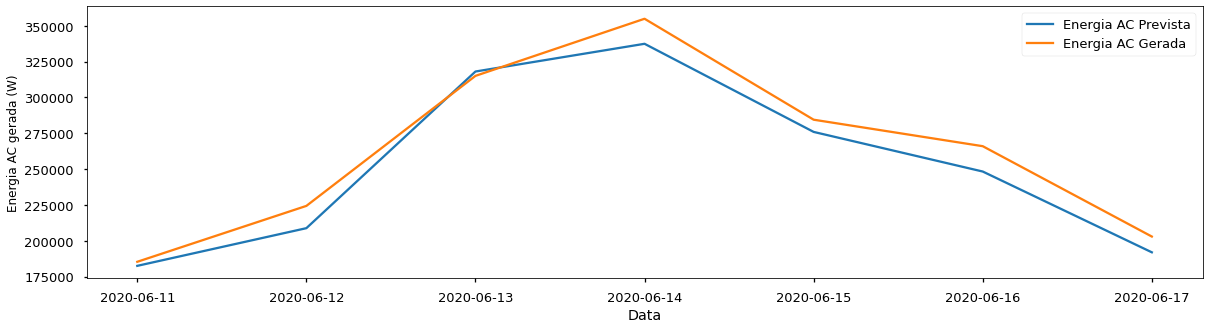

In [33]:
# Previsão da amostra de teste - RL (Últimos 10 dias)
previsoesPlot = teste.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesPlot['AC_POWER_FUTURO'] = previsaoTesteNormalizadoInvertido_RL

# Plotar gráfico
previsoesPlot['Data'] = previsoesPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesPlot = previsoesPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesPlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Prevista')

testePlot = teste.copy()
testePlot['Data'] = testePlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
testePlot = testePlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
testePlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Gerada')

plt.ylabel('Energia AC gerada (W)',fontsize=12)
plt.legend()
plt.show()

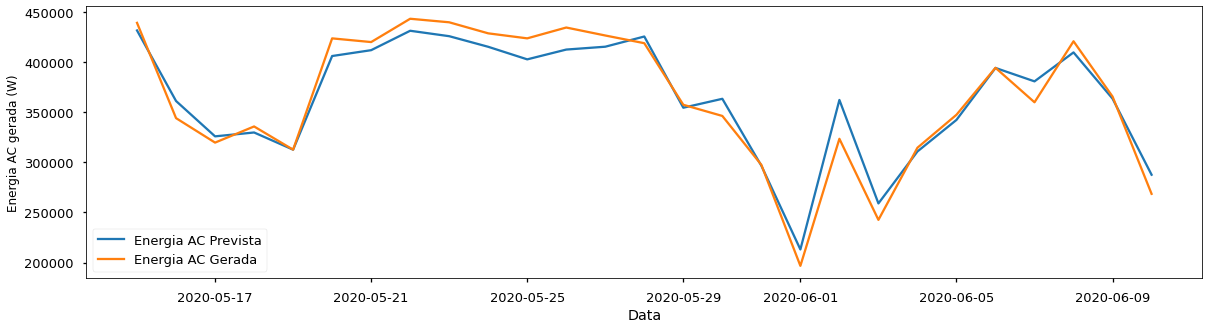

In [34]:
# Previsão da amostra de treino - RL (Primeiros 34 dias)
previsoesPlot = treino.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesPlot['AC_POWER_FUTURO'] = previsaoTreinoNormalizadoInvertido_RL

# Plotar gráfico
previsoesPlot['Data'] = previsoesPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesPlot = previsoesPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesPlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Prevista')

treinoPlot = treino.copy()
treinoPlot['Data'] = treinoPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
treinoPlot = treinoPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
treinoPlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Gerada')

plt.ylabel('Energia AC gerada (W)',fontsize=12)
plt.legend()
plt.show()

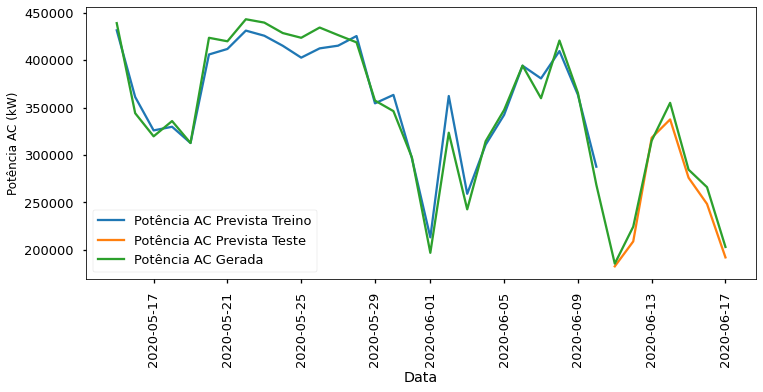

In [35]:
# Previsão da amostra completa - RL Multi
# Plotar gráfico previsão treino
previsoesTreinoPlot = treino.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesTreinoPlot['AC_POWER_FUTURO'] = previsaoTreinoNormalizadoInvertido_RL

previsoesTreinoPlot['Data'] = previsoesTreinoPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesTreinoPlot = previsoesTreinoPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesTreinoPlot['AC_POWER_FUTURO'].plot(figsize=(12,5),label='Potência AC Prevista Treino')

# Plotar gráfico previsão teste
previsoesTestePlot = teste.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesTestePlot['AC_POWER_FUTURO'] = previsaoTesteNormalizadoInvertido_RL

previsoesTestePlot['Data'] = previsoesTestePlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesTestePlot = previsoesTestePlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesTestePlot['AC_POWER_FUTURO'].plot(figsize=(12,5),label='Potência AC Prevista Teste')

# Plotar gráfico original
completoPlot = dtGeracaoEnergia.copy()
completoPlot['Data'] = completoPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
completoPlot = completoPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
completoPlot['AC_POWER_FUTURO'].plot(figsize=(12,5),label='Potência AC Gerada')

plt.ylabel('Potência AC (kW)',fontsize=12)
plt.xticks(rotation = 90)
plt.legend()
plt.savefig(diretorioImagens + '/' + nomeModelo + '_completa.png', format='png', bbox_inches='tight')
plt.show()

## 3.4 Erro RMSE

In [36]:
print(teste['AC_POWER_FUTURO'].mean())

419.78144415617805


In [37]:
# Cálculo do RMSE para amostra teste
testScore_RL = math.sqrt(mean_squared_error(np.array(teste['AC_POWER_FUTURO']), previsaoTesteNormalizadoInvertido_RL))
print("O valor do RMSE para a amostra teste é: " + str(testScore_RL))

# Cálculo do RMSE para amostra treino
treinoScore_RL = math.sqrt(mean_squared_error(np.array(treino['AC_POWER_FUTURO']), previsaoTreinoNormalizadoInvertido_RL))
print("O valor do RMSE para a amostra treino é: " + str(treinoScore_RL))

# Cálculo do RMSE para amostra completa
completoScore_RL = math.sqrt(mean_squared_error(np.array(dtGeracaoEnergia['AC_POWER_FUTURO']), previsaoCompletoNormalizadoInvertido_RL))
print("O valor do RMSE para a amostra completa é: " + str(completoScore_RL))

O valor do RMSE para a amostra teste é: 121.96722559703244
O valor do RMSE para a amostra treino é: 149.16091763701883
O valor do RMSE para a amostra completa é: 143.97169239380608


In [38]:
# Calcular erro RMSE para amostra completa normalizada
# Função para calcular erro RMSE
def rmse(previsoes, alvos):
    return np.sqrt(((previsoes - alvos) ** 2).mean())

rmse_val = rmse(previsaoCompletoNormalizadoInvertido_RL, np.array(dtGeracaoEnergia['AC_POWER_FUTURO']))

print('O valor RMSE é: ' + str(rmse_val))

O valor RMSE é: 544.6028123178453


# 4. Modelagem com RL Polinomial


In [39]:
treinoX = dataset_treino_normalizado[:,:-1]
treinoY = dataset_treino_normalizado[:,-1].reshape(-1,1)

testeX = dataset_teste_normalizado[:,:-1]
testeY = dataset_teste_normalizado[:,-1].reshape(-1,1)

completoX = dataset_completo_normalizado[:,:-1]
completoY = dataset_completo_normalizado[:,-1].reshape(-1,1)

In [40]:
# Formato dos dados previstos para teste
print(testeX.shape, testeY.shape)

# Formato dos dados previstos para treino
print(treinoX.shape, treinoY.shape)

# Formato dos dados previstos para a amostra completa
print(completoX.shape, completoY.shape)

(4367, 1) (4367, 1)
(16800, 1) (16800, 1)
(21167, 1) (21167, 1)


In [41]:
treinoX

array([[0.01179685],
       [0.01179685],
       [0.01179685],
       ...,
       [0.00699281],
       [0.00699281],
       [0.00699281]])

In [42]:
treinoY

array([[0.01076324],
       [0.01089379],
       [0.01064236],
       ...,
       [0.01049592],
       [0.0098328 ],
       [0.06149457]])

In [43]:
# Treinamento do modelo linear polinomial
nomeModelo = 'RL_Poli'

# regressao Polinomial de Ordem d
d = 2
model_poly = make_pipeline(PolynomialFeatures(d), LinearRegression())
model_poly.fit(treinoX, treinoY)

# Previsão da amostra de teste - LSTM
previsaoTesteNormalizado = model_poly.predict(testeX)

# Previsão da amostra de treino - LSTM
previsaoTreinoNormalizado = model_poly.predict(treinoX)

# Previsão da amostra completa - LSTM
previsaoCompletoNormalizado = model_poly.predict(completoX)

## 4.1 Erro MSE

In [44]:
#Erro quadrático médio (MSE)
desempenho_treino = mean_squared_error(treinoY, previsaoTreinoNormalizado)
print(f'Desempenho do treinamento: {desempenho_treino} MSE')

desempenho_teste = mean_squared_error(testeY, previsaoTesteNormalizado)
print(f'Desempenho do teste: {desempenho_teste} MSE')

desempenho_completo = mean_squared_error(completoY, previsaoCompletoNormalizado)
print(f'Desempenho da amostra completa: {desempenho_completo} MSE')

Desempenho do treinamento: 0.011486207706956813 MSE
Desempenho do teste: 0.007491393929060991 MSE
Desempenho da amostra completa: 0.010662030838809646 MSE


In [45]:
desempenho_treino_rmse = math.sqrt(mean_squared_error(treinoY, previsaoTreinoNormalizado))
print(f'Desempenho do treinamento: {desempenho_treino_rmse} RMSE')

desempenho_teste_rmse = math.sqrt(mean_squared_error(testeY, previsaoTesteNormalizado))
print(f'Desempenho do teste: {desempenho_teste_rmse} RMSE')

desempenho_completo_rmse = math.sqrt(mean_squared_error(completoY, previsaoCompletoNormalizado))
print(f'Desempenho da amostra completa: {desempenho_completo_rmse} RMSE')

Desempenho do treinamento: 0.1071737267568727 RMSE
Desempenho do teste: 0.08655283894281568 RMSE
Desempenho da amostra completa: 0.10325711035473366 RMSE


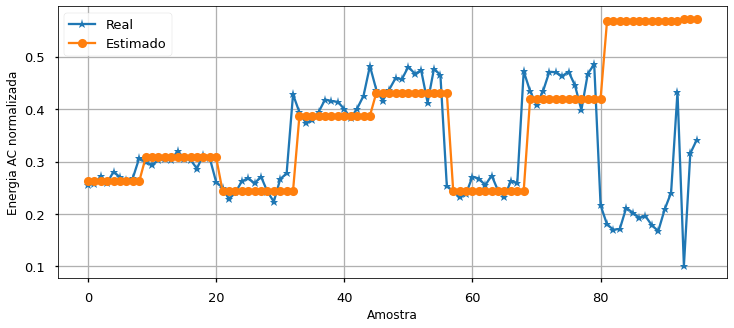

In [46]:
# Desempenho no teste
i=1779
j=i+48*2
plt.figure(figsize=(12,5))
plt.plot(range(j-i), testeY[i:j],'-*' ,range(j-i), previsaoTesteNormalizado[i:j],'-o')
plt.legend(('Real','Estimado'))
plt.xlabel('Amostra',fontsize=12)
plt.ylabel('Energia AC normalizada',fontsize=12)
plt.savefig(diretorioImagens + '/Desempenho_Teste_' + nomeModelo + '.png', format='png', bbox_inches='tight')
plt.grid()
plt.show()

## 4.2 Invertendo Normalização

In [47]:
# Imprime valores minímos e máximos
# min_ = min - X.min(axis=0) * self.scale_
# scale_ = (max - min) / (X.max(axis=0) - X.min(axis=0))
# data_min_ = valor mínimo na amostra
# data_max_ = valor máximo na amostra
scaler_com_dados_treino.min_, scaler_com_dados_treino.scale_, scaler_com_dados_treino.data_min_, scaler_com_dados_treino.data_max_

(array([0., 0.]),
 array([9.10111853e-01, 7.25285884e-04]),
 array([0., 0.]),
 array([1.09876604e+00, 1.37876667e+03]))

In [48]:
# Invertendo normalização para interpretação dos resultados
scale = MinMaxScaler()
scale.min_, scale.scale_ = scaler_com_dados_treino.min_[treinoX.shape[1]], scaler_com_dados_treino.scale_[treinoX.shape[1]]

# Para amostra de teste
previsaoTesteNormalizadoInvertido_RL = scale.inverse_transform(previsaoTesteNormalizado) # Inverte normalização para os valores previstos de teste

# Para amostra de treino
previsaoTreinoNormalizadoInvertido_RL = scale.inverse_transform(previsaoTreinoNormalizado)

# Para amostra completa
previsaoCompletoNormalizadoInvertido_RL = scale.inverse_transform(previsaoCompletoNormalizado)

## 4.3 Resultado das Previsões

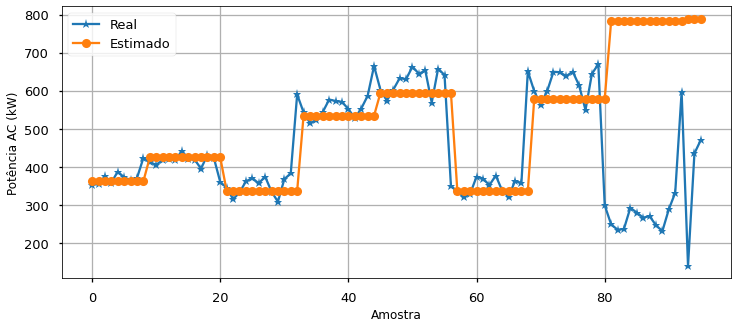

In [49]:
i=1779
j=i+48*2
plt.figure(figsize=(12,5))
plt.plot(range(j-i), np.array(teste['AC_POWER_FUTURO'][i:j]),'-*' ,range(j-i), previsaoTesteNormalizadoInvertido_RL[i:j],'-o')
plt.legend(('Real','Estimado'))
plt.xlabel('Amostra',fontsize=12)
plt.ylabel('Potência AC (kW)',fontsize=12)
plt.savefig(diretorioImagens + '/Desempenho_Teste_Invertido' + nomeModelo + '.png', format='png', bbox_inches='tight')
plt.grid()
plt.show()

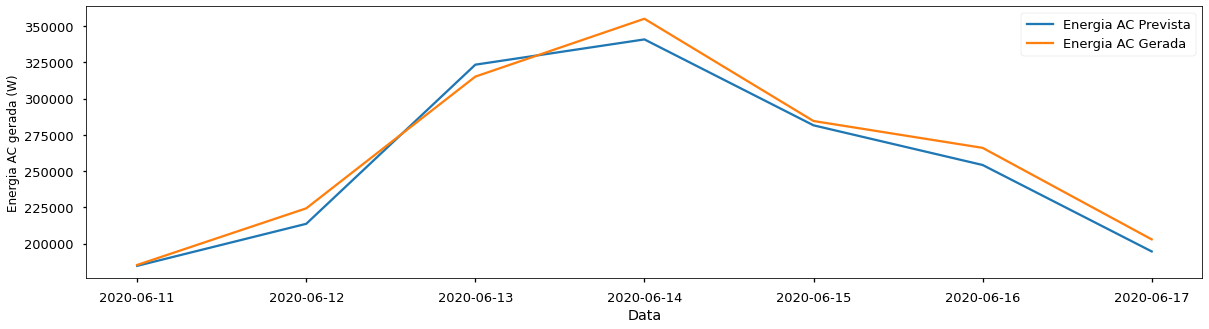

In [50]:
# Previsão da amostra de teste - RL (Últimos 10 dias)
previsoesPlot = teste.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesPlot['AC_POWER_FUTURO'] = previsaoTesteNormalizadoInvertido_RL

# Plotar gráfico
previsoesPlot['Data'] = previsoesPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesPlot = previsoesPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesPlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Prevista')

testePlot = teste.copy()
testePlot['Data'] = testePlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
testePlot = testePlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
testePlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Gerada')

plt.ylabel('Energia AC gerada (W)',fontsize=12)
plt.legend()
plt.show()

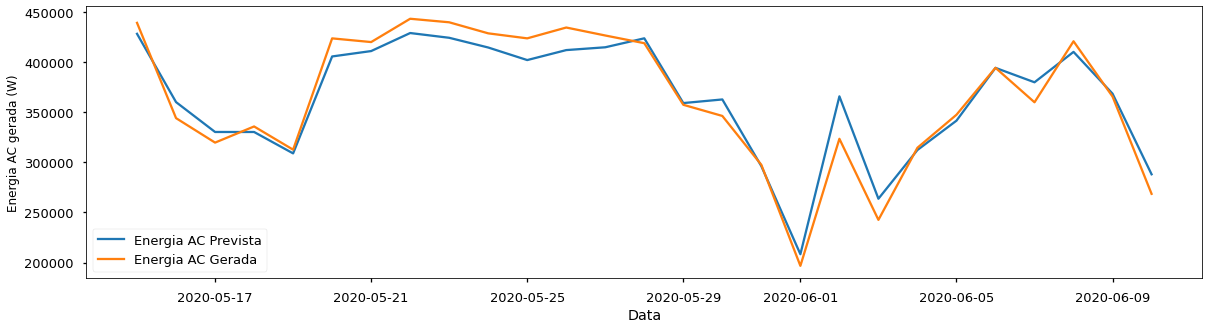

In [51]:
# Previsão da amostra de treino - RL (Primeiros 34 dias)
previsoesPlot = treino.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesPlot['AC_POWER_FUTURO'] = previsaoTreinoNormalizadoInvertido_RL

# Plotar gráfico
previsoesPlot['Data'] = previsoesPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesPlot = previsoesPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesPlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Prevista')

treinoPlot = treino.copy()
treinoPlot['Data'] = treinoPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
treinoPlot = treinoPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
treinoPlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Gerada')

plt.ylabel('Energia AC gerada (W)',fontsize=12)
plt.legend()
plt.show()

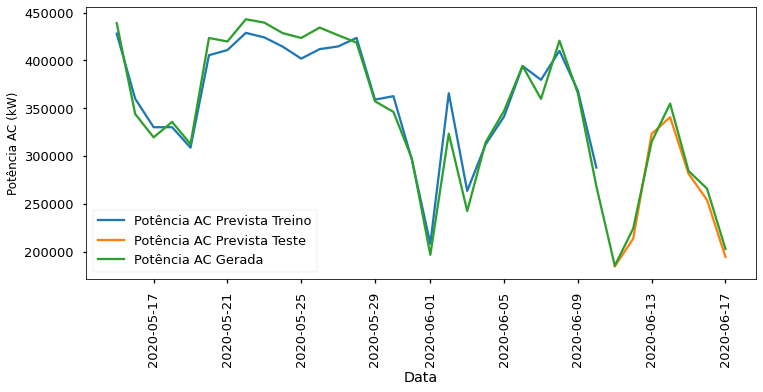

In [52]:
# Previsão da amostra completa - RL
# Plotar gráfico previsão treino
previsoesTreinoPlot = treino.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesTreinoPlot['AC_POWER_FUTURO'] = previsaoTreinoNormalizadoInvertido_RL

previsoesTreinoPlot['Data'] = previsoesTreinoPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesTreinoPlot = previsoesTreinoPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesTreinoPlot['AC_POWER_FUTURO'].plot(figsize=(12,5),label='Potência AC Prevista Treino')

# Plotar gráfico previsão teste
previsoesTestePlot = teste.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesTestePlot['AC_POWER_FUTURO'] = previsaoTesteNormalizadoInvertido_RL

previsoesTestePlot['Data'] = previsoesTestePlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesTestePlot = previsoesTestePlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesTestePlot['AC_POWER_FUTURO'].plot(figsize=(12,5),label='Potência AC Prevista Teste')

# Plotar gráfico original
completoPlot = dtGeracaoEnergia.copy()
completoPlot['Data'] = completoPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
completoPlot = completoPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
completoPlot['AC_POWER_FUTURO'].plot(figsize=(12,5),label='Potência AC Gerada')

plt.ylabel('Potência AC (kW)',fontsize=12)
plt.xticks(rotation = 90)
plt.legend()
plt.savefig(diretorioImagens + '/' + nomeModelo + '_completa.png', format='png', bbox_inches='tight')
plt.show()

## 4.4 Erro RMSE

In [53]:
# Cálculo do RMSE para amostra teste
testScore_RL = math.sqrt(mean_squared_error(np.array(teste['AC_POWER_FUTURO']), previsaoTesteNormalizadoInvertido_RL))
print("O valor do RMSE para a amostra teste é: " + str(testScore_RL))

# Cálculo do RMSE para amostra treino
treinoScore_RL = math.sqrt(mean_squared_error(np.array(treino['AC_POWER_FUTURO']), previsaoTreinoNormalizadoInvertido_RL))
print("O valor do RMSE para a amostra treino é: " + str(treinoScore_RL))

# Cálculo do RMSE para amostra completa
completoScore_RL = math.sqrt(mean_squared_error(np.array(dtGeracaoEnergia['AC_POWER_FUTURO']), previsaoCompletoNormalizadoInvertido_RL))
print("O valor do RMSE para a amostra completa é: " + str(completoScore_RL))

O valor do RMSE para a amostra teste é: 119.33616923972285
O valor do RMSE para a amostra treino é: 147.76756199481756
O valor do RMSE para a amostra completa é: 142.36746185342832


In [54]:
# Calcular erro RMSE para amostra completa normalizada
# Função para calcular erro RMSE
def rmse(previsoes, alvos):
    return np.sqrt(((previsoes - alvos) ** 2).mean())

rmse_val = rmse(previsaoCompletoNormalizadoInvertido_RL, np.array(dtGeracaoEnergia['AC_POWER']))

print('O valor RMSE é: ' + str(rmse_val))

O valor RMSE é: 545.6447600157024


# 5. Modelagem com MLP - Vanilla

In [55]:
# Divide uma sequência com múltiplos atributos em duas amostras
def criar_amostra(sequencias, look_back):
    Entrada, saida = list(), list()
    for i in range(len(sequencias)):
        # Olha para trás de acordo com a quantidade de passos desejados
        end_ix = i + look_back
        # Verifica se existem dados para olhar para trás na amostra de entrada
        if end_ix > len(sequencias)-1:
            break
        # Separa a amostra de entrada em "Entrada" e "Saída"
        seq_x = sequencias[i:end_ix, :-1] # Coleta os valores de entrada
        seq_y = sequencias[end_ix - 1, -1] # Coleta os valores de saída futuros
        Entrada.append(seq_x)
        saida.append(seq_y)
    return np.array(Entrada), np.array(saida)

In [56]:
look_back = 1

treinoX_normalizado, treinoY_normalizado = criar_amostra(dataset_treino_normalizado, look_back)
testeX_normalizado, testeY_normalizado = criar_amostra(dataset_teste_normalizado, look_back)
completoX_normalizado, completoY_normalizado = criar_amostra(dataset_completo_normalizado, look_back)

# Imprimir primeira linha da entrada do dataset de treino
print(treinoX_normalizado[0:3])

# Imprimir primeira linha da saída do dataset de treino (Percebe-se que o primeiro item é o valor futuro da amostra completa)
print("\n", treinoY_normalizado[0:3])

[[[0.01179685]]

 [[0.01179685]]

 [[0.01179685]]]

 [0.01076324 0.01089379 0.01064236]


In [57]:
# Formato dos dados de treino
print(treinoX_normalizado.shape, treinoY_normalizado.shape)

# Formato dos dados de teste
print(testeX_normalizado.shape, testeY_normalizado.shape)

# Formato dos dados da amostra compelta
print(completoX_normalizado.shape, completoY_normalizado.shape)

(16799, 1, 1) (16799,)
(4366, 1, 1) (4366,)
(21166, 1, 1) (21166,)


In [58]:
# Criando modelo MLP
# A rede possui camada visível com 1 entrada
# Camada oculta com 64 blocos MLP ou neurônios
# 1 camada de saída
# Função de ativação sigmoide padrão
# Tamanho de lote (batch size) igual a 32

nomeModelo = 'MLP_Vanilla' + nomeEntrada

n_atributos = treinoX_normalizado.shape[2]

neuroniosMLP = 64
batchSizeMLP = 32
epocasMLP = 200
qtdCamadasMLP = 1

reset_random_seeds()

model_MLP_vanilla = Sequential()
model_MLP_vanilla.add(layers.Dense(neuroniosMLP, input_shape = (look_back, n_atributos), activation = 'sigmoid'))
model_MLP_vanilla.add(layers.Flatten())
model_MLP_vanilla.add(layers.Dense(1)) # camada de saída

# Compilação
model_MLP_vanilla.compile(loss = "mean_squared_error", optimizer = 'adam')
model_MLP_vanilla.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 64)             128       
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [59]:
# Reduz o platô, ou seja, percebe se o treinamento entrou em um ponto de cela
rlronp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Interrompe o treinamento quando não calcular nenhum progresso na validação definida para várias épocsa
early_stopping_MLP = EarlyStopping(monitor='val_loss', mode='min', patience = 10, verbose=1, restore_best_weights = True)

# Checkpoint, salva os pontos de verificação do modelo em intervalos regulares durante o treinamento, por padrão no fim de cada época, além disso, com save_best_only, salva somente o melhor modelo
checkpoint_MLP = ModelCheckpoint(diretorioModelos + '/' + nomeModelo + '_' + str(neuroniosMLP) + '_' + str(batchSizeMLP) + '_' + str(epocasMLP) + '_' + str(qtdCamadasMLP) + '.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [60]:
reset_random_seeds()

# Fit do modelo
# validation_split = 0,1 - seleciona 10% dos dados de treinamento para realizar a validação durante o treino, isto é necessário para avaliar o desempenho do modelo com dados novos, visto que 10%
# dos dados de treinamento não serão utilizados no treino mas sim para verificar se estão sendo previstos adequadamente, auxilia a perceber se o modelo está causando overfitting
# isto é utilizado também para a função save_best_only, onde somente o modelo com melhor desempenho será salvo
historico_MLP = model_MLP_vanilla.fit(treinoX_normalizado, treinoY_normalizado, epochs = epocasMLP, batch_size = batchSizeMLP, verbose = 2, validation_split = 0.15,
                        callbacks = [rlronp, early_stopping_MLP, checkpoint_MLP])

# Salvar modelo
model_MLP_vanilla.save(diretorioModelos + '/' + nomeModelo + '_' + str(neuroniosMLP) + '_' + str(batchSizeMLP) + '_' + str(epocasMLP) + '_' + str(qtdCamadasMLP) + '.h5')

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.01813, saving model to /content/drive/MyDrive/TCC/Modelos/MLP_Vanilla_64_32_200_1.h5
447/447 - 3s - loss: 0.0634 - val_loss: 0.0181 - lr: 0.0010 - 3s/epoch - 7ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.01813 to 0.01509, saving model to /content/drive/MyDrive/TCC/Modelos/MLP_Vanilla_64_32_200_1.h5
447/447 - 1s - loss: 0.0127 - val_loss: 0.0151 - lr: 0.0010 - 1s/epoch - 3ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.01509
447/447 - 1s - loss: 0.0112 - val_loss: 0.0152 - lr: 0.0010 - 1s/epoch - 2ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.01509
447/447 - 1s - loss: 0.0112 - val_loss: 0.0159 - lr: 0.0010 - 952ms/epoch - 2ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.01509
447/447 - 1s - loss: 0.0112 - val_loss: 0.0152 - lr: 5.0000e-04 - 951ms/epoch - 2ms/step
Epoch 6/200

Epoch 6: val_loss did not improve from 0.01509
447/447 - 1s - loss: 0.0112 - val_loss: 0.0152 - lr: 5.000

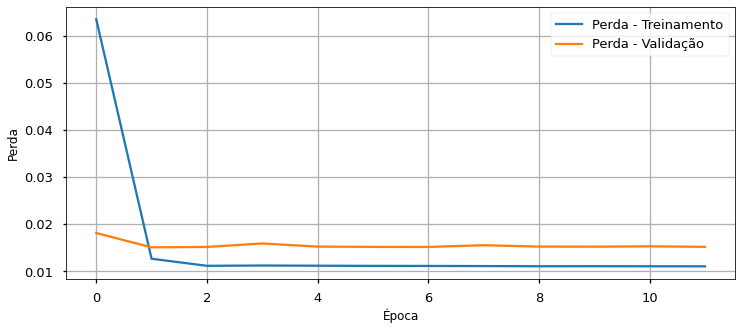

In [61]:
plt.figure(figsize=(12,5))
plt.plot(historico_MLP.history['loss'], label = 'Perda - Treinamento')
plt.plot(historico_MLP.history['val_loss'], label = 'Perda - Validação')
plt.grid()
plt.xlabel('Época',fontsize=12)
plt.ylabel('Perda',fontsize=12)
plt.legend()
plt.savefig(diretorioImagens + '/Perdas_' + nomeModelo + '_' + str(neuroniosMLP) + '_' + str(batchSizeMLP) + '_' + str(epocasMLP) + '_' + str(qtdCamadasMLP) + '.png', format='png', bbox_inches='tight')

## 5.1 Previsões

In [62]:
# Previsão da amostra de teste - MLP
previsaoTesteNormalizado_MLP = model_MLP_vanilla.predict(testeX_normalizado)

# Previsão da amostra de treino - MLP
previsaoTreinoNormalizado_MLP = model_MLP_vanilla.predict(treinoX_normalizado)

# Previsão da amostra completa - MLP
previsaoCompletoNormalizado_MLP = model_MLP_vanilla.predict(completoX_normalizado)

In [63]:
# Formato dos dados previstos para teste
print(previsaoTesteNormalizado_MLP.shape, teste.shape)

# Formato dos dados previstos para treino
print(previsaoTreinoNormalizado_MLP.shape, treino.shape)

# Formato dos dados previstos para a amostra completa
print(previsaoCompletoNormalizado_MLP.shape, dtGeracaoEnergia.shape)

(4366, 1) (4367, 9)
(16799, 1) (16800, 9)
(21166, 1) (21167, 9)


## 5.2 Erro MSE

In [64]:
desempenho_treino = mean_squared_error(treinoY_normalizado, previsaoTreinoNormalizado_MLP)
print(f'Desempenho do treinamento: {desempenho_treino} MSE')

desempenho_teste = mean_squared_error(testeY_normalizado, previsaoTesteNormalizado_MLP)
print(f'Desempenho do teste: {desempenho_teste} MSE')

desempenho_completo = mean_squared_error(completoY_normalizado, previsaoCompletoNormalizado_MLP)
print(f'Desempenho da amostra completa: {desempenho_completo} MSE')

Desempenho do treinamento: 0.011688338652592145 MSE
Desempenho do teste: 0.007784278576138214 MSE
Desempenho da amostra completa: 0.01088251400353523 MSE


In [65]:
desempenho_treino_rmse = math.sqrt(mean_squared_error(treinoY_normalizado, previsaoTreinoNormalizado_MLP))
print(f'Desempenho do treinamento: {desempenho_treino_rmse} RMSE')

desempenho_teste_rmse = math.sqrt(mean_squared_error(testeY_normalizado, previsaoTesteNormalizado_MLP))
print(f'Desempenho do teste: {desempenho_teste_rmse} RMSE')

desempenho_completo_rmse = math.sqrt(mean_squared_error(completoY_normalizado, previsaoCompletoNormalizado_MLP))
print(f'Desempenho da amostra completa: {desempenho_completo_rmse} RMSE')

Desempenho do treinamento: 0.1081126202281313 RMSE
Desempenho do teste: 0.08822855873320279 RMSE
Desempenho da amostra completa: 0.10431928874151333 RMSE


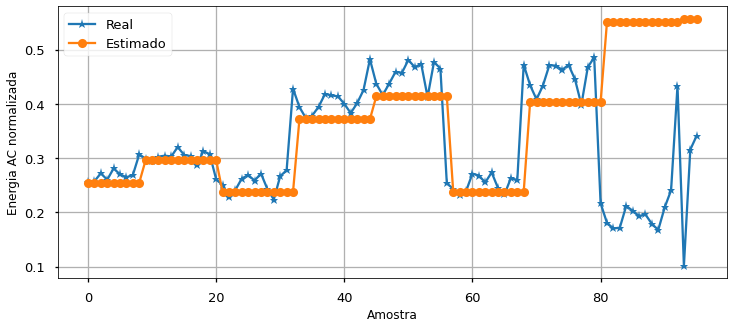

In [66]:
i=1779
j=i+48*2
plt.figure(figsize=(12,5))
plt.plot(range(j-i), testeY_normalizado[i:j],'-*' ,range(j-i), previsaoTesteNormalizado_MLP[i:j],'-o')
plt.legend(('Real','Estimado'))
plt.xlabel('Amostra',fontsize=12)
plt.ylabel('Energia AC normalizada',fontsize=12)
plt.savefig(diretorioImagens + '/Desempenho_Teste_' + nomeModelo + '.png', format='png', bbox_inches='tight')
plt.grid()
plt.show()

## 5.3 Preparando amostras reais

Para gerar o gráfico posteriormente será necessário remover uma linha de dado das amostras reais.

In [67]:
teste

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,HOUR,AC_POWER,AC_POWER_FUTURO
2592,2020-06-11 06:00:00,81aHJ1q11NBPMrL,24.265365,23.726226,0.004264,11,6,0.700000,0.685714
2593,2020-06-11 06:00:00,9kRcWv60rDACzjR,24.265365,23.726226,0.004264,11,6,0.685714,0.614286
2594,2020-06-11 06:00:00,LYwnQax7tkwH5Cb,24.265365,23.726226,0.004264,11,6,0.614286,0.000000
2595,2020-06-11 06:00:00,LlT2YUhhzqhg5Sw,24.265365,23.726226,0.004264,11,6,0.000000,0.573333
2596,2020-06-11 06:00:00,PeE6FRyGXUgsRhN,24.265365,23.726226,0.004264,11,6,0.573333,1.366667
...,...,...,...,...,...,...,...,...,...
21162,2020-06-17 17:45:00,WcxssY2VbP4hApt,26.091664,27.235657,0.065480,17,17,97.046667,96.620000
21163,2020-06-17 17:45:00,oZZkBaNadn6DNKz,26.091664,27.235657,0.065480,17,17,96.620000,94.700000
21164,2020-06-17 17:45:00,q49J1IKaHRwDQnt,26.091664,27.235657,0.065480,17,17,94.700000,89.680000
21165,2020-06-17 17:45:00,rrq4fwE8jgrTyWY,26.091664,27.235657,0.065480,17,17,89.680000,96.693333


In [68]:
from matplotlib.cbook import local_over_kwdict

# Removendo linhas da amostra real
teste_reshape = teste.copy()
treino_reshape = treino.copy()
completo_reshape = dtGeracaoEnergia.copy()

for i in range(look_back - 1):
    teste_reshape = teste_reshape.drop([teste.index[i]])
    treino_reshape = treino_reshape.drop([treino.index[i]])
    completo_reshape = completo_reshape.drop([dtGeracaoEnergia.index[i]])

teste_reshape = teste_reshape.drop([teste.index[-1]])
treino_reshape = treino_reshape.drop([treino.index[-1]])
completo_reshape = completo_reshape.drop([dtGeracaoEnergia.index[-1]])

In [69]:
# Invertendo normalização das amostras reais para comparar e verificar se as data tables foram corretamente filtradas
scale = MinMaxScaler()

scale.min_, scale.scale_ = scaler_com_dados_treino.min_[treinoX_normalizado.shape[2]], scaler_com_dados_treino.scale_[treinoX_normalizado.shape[2]]

# Para amostra real teste
testeY_invertido =  scale.inverse_transform(testeY_normalizado.reshape(-1,1))

# Para amostra real teste
treinoY_invertido =  scale.inverse_transform(treinoY_normalizado.reshape(-1,1))

# Para amostra real teste
completoY_invertido =  scale.inverse_transform(completoY_normalizado.reshape(-1,1))

In [70]:
# Amostra real não normalizada utilizada para comparar com os dados previstos
print(testeY_invertido)

[[ 0.68571429]
 [ 0.61428571]
 [ 0.        ]
 ...
 [94.7       ]
 [89.68      ]
 [96.69333333]]


In [71]:
teste_reshape

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,HOUR,AC_POWER,AC_POWER_FUTURO
2592,2020-06-11 06:00:00,81aHJ1q11NBPMrL,24.265365,23.726226,0.004264,11,6,0.700000,0.685714
2593,2020-06-11 06:00:00,9kRcWv60rDACzjR,24.265365,23.726226,0.004264,11,6,0.685714,0.614286
2594,2020-06-11 06:00:00,LYwnQax7tkwH5Cb,24.265365,23.726226,0.004264,11,6,0.614286,0.000000
2595,2020-06-11 06:00:00,LlT2YUhhzqhg5Sw,24.265365,23.726226,0.004264,11,6,0.000000,0.573333
2596,2020-06-11 06:00:00,PeE6FRyGXUgsRhN,24.265365,23.726226,0.004264,11,6,0.573333,1.366667
...,...,...,...,...,...,...,...,...,...
21161,2020-06-17 17:45:00,V94E5Ben1TlhnDV,26.091664,27.235657,0.065480,17,17,95.106667,97.046667
21162,2020-06-17 17:45:00,WcxssY2VbP4hApt,26.091664,27.235657,0.065480,17,17,97.046667,96.620000
21163,2020-06-17 17:45:00,oZZkBaNadn6DNKz,26.091664,27.235657,0.065480,17,17,96.620000,94.700000
21164,2020-06-17 17:45:00,q49J1IKaHRwDQnt,26.091664,27.235657,0.065480,17,17,94.700000,89.680000


In [72]:
# Amostra real não normalizada utilizada para comparar com os dados previstos
print(treinoY_invertido)

[[14.84      ]
 [15.02      ]
 [14.67333333]
 ...
 [13.6       ]
 [14.47142857]
 [13.55714286]]


In [73]:
treino_reshape

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,HOUR,AC_POWER,AC_POWER_FUTURO
0,2020-05-15 06:00:00,81aHJ1q11NBPMrL,24.742787,24.077230,0.012962,15,6,14.246667,14.840000
1,2020-05-15 06:00:00,9kRcWv60rDACzjR,24.742787,24.077230,0.012962,15,6,14.840000,15.020000
2,2020-05-15 06:00:00,LYwnQax7tkwH5Cb,24.742787,24.077230,0.012962,15,6,15.020000,14.673333
3,2020-05-15 06:00:00,LlT2YUhhzqhg5Sw,24.742787,24.077230,0.012962,15,6,14.673333,13.993333
4,2020-05-15 06:00:00,PeE6FRyGXUgsRhN,24.742787,24.077230,0.012962,15,6,13.993333,14.680000
...,...,...,...,...,...,...,...,...,...
17466,2020-06-10 17:45:00,WcxssY2VbP4hApt,27.759774,25.464606,0.007683,10,17,14.264286,13.207143
17467,2020-06-10 17:45:00,oZZkBaNadn6DNKz,27.759774,25.464606,0.007683,10,17,13.207143,14.257143
17468,2020-06-10 17:45:00,q49J1IKaHRwDQnt,27.759774,25.464606,0.007683,10,17,14.257143,13.600000
17469,2020-06-10 17:45:00,rrq4fwE8jgrTyWY,27.759774,25.464606,0.007683,10,17,13.600000,14.471429


In [74]:
# Amostra real não normalizada utilizada para comparar com os dados previstos
print(completoY_invertido)

[[14.84      ]
 [15.02      ]
 [14.67333333]
 ...
 [94.7       ]
 [89.68      ]
 [96.69333333]]


In [75]:
completo_reshape

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,HOUR,AC_POWER,AC_POWER_FUTURO
0,2020-05-15 06:00:00,81aHJ1q11NBPMrL,24.742787,24.077230,0.012962,15,6,14.246667,14.840000
1,2020-05-15 06:00:00,9kRcWv60rDACzjR,24.742787,24.077230,0.012962,15,6,14.840000,15.020000
2,2020-05-15 06:00:00,LYwnQax7tkwH5Cb,24.742787,24.077230,0.012962,15,6,15.020000,14.673333
3,2020-05-15 06:00:00,LlT2YUhhzqhg5Sw,24.742787,24.077230,0.012962,15,6,14.673333,13.993333
4,2020-05-15 06:00:00,PeE6FRyGXUgsRhN,24.742787,24.077230,0.012962,15,6,13.993333,14.680000
...,...,...,...,...,...,...,...,...,...
21161,2020-06-17 17:45:00,V94E5Ben1TlhnDV,26.091664,27.235657,0.065480,17,17,95.106667,97.046667
21162,2020-06-17 17:45:00,WcxssY2VbP4hApt,26.091664,27.235657,0.065480,17,17,97.046667,96.620000
21163,2020-06-17 17:45:00,oZZkBaNadn6DNKz,26.091664,27.235657,0.065480,17,17,96.620000,94.700000
21164,2020-06-17 17:45:00,q49J1IKaHRwDQnt,26.091664,27.235657,0.065480,17,17,94.700000,89.680000


In [76]:
# Comparação entre os formatos da previsão e dos dados para plotar o gráfico real
print(previsaoTesteNormalizado_MLP.shape, teste_reshape.shape)

# Comparação entre os formatos da previsão e dos dados para plotar o gráfico real
print(previsaoTreinoNormalizado_MLP.shape, treino_reshape.shape)

# Comparação entre os formatos da previsão e dos dados para plotar o gráfico real
print(previsaoCompletoNormalizado_MLP.shape, completo_reshape.shape)

(4366, 1) (4366, 9)
(16799, 1) (16799, 9)
(21166, 1) (21166, 9)


## 5.4 Invertendo Normalização

In [77]:
# Imprime valores minímos e máximos
# min_ = min - X.min(axis=0) * self.scale_
# scale_ = (max - min) / (X.max(axis=0) - X.min(axis=0))
# data_min_ = valor mínimo na amostra
# data_max_ = valor máximo na amostra
scaler_com_dados_treino.min_, scaler_com_dados_treino.scale_, scaler_com_dados_treino.data_min_, scaler_com_dados_treino.data_max_

(array([0., 0.]),
 array([9.10111853e-01, 7.25285884e-04]),
 array([0., 0.]),
 array([1.09876604e+00, 1.37876667e+03]))

In [78]:
# Invertendo normalização para interpretação dos resultados
scale = MinMaxScaler()
scale.min_, scale.scale_ = scaler_com_dados_treino.min_[treinoX_normalizado.shape[2]], scaler_com_dados_treino.scale_[treinoX_normalizado.shape[2]]

# Para amostra de teste
previsaoTesteNormalizadoInvertido_MLP = scale.inverse_transform(previsaoTesteNormalizado_MLP) # Inverte normalização para os valores previstos de teste

# Para amostra de treino
previsaoTreinoNormalizadoInvertido_MLP = scale.inverse_transform(previsaoTreinoNormalizado_MLP)

# Para amostra completa
previsaoCompletoNormalizadoInvertido_MLP = scale.inverse_transform(previsaoCompletoNormalizado_MLP)

## 5.5 Resultado das Previsões

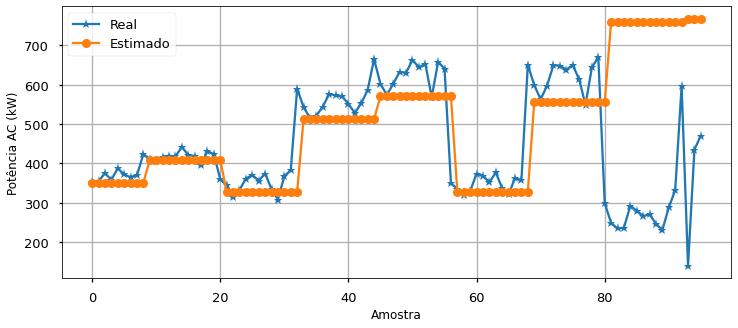

In [79]:
i=1779
j=i+48*2
plt.figure(figsize=(12,5))
plt.plot(range(j-i), np.array(teste_reshape['AC_POWER_FUTURO'][i:j]),'-*' ,range(j-i), previsaoTesteNormalizadoInvertido_MLP[i:j],'-o')
plt.legend(('Real','Estimado'))
plt.xlabel('Amostra',fontsize=12)
plt.ylabel('Potência AC (kW)',fontsize=12)
plt.savefig(diretorioImagens + '/Desempenho_Teste_Invertido' + nomeModelo + '.png', format='png', bbox_inches='tight')
plt.grid()
plt.show()

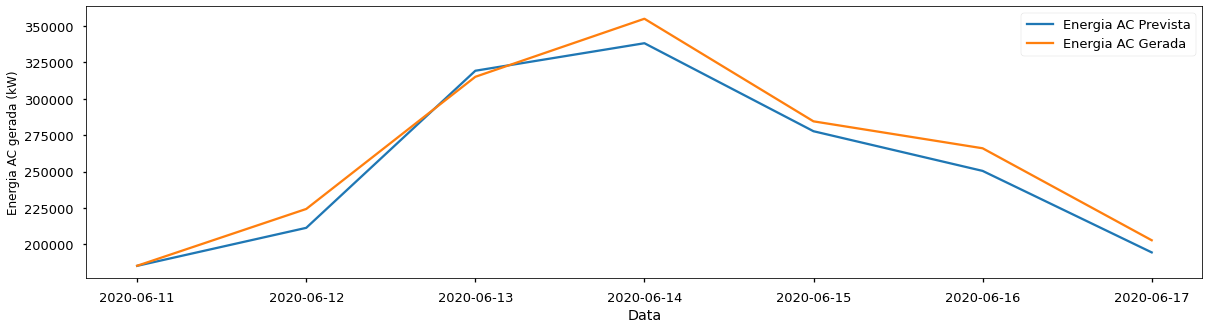

In [80]:
# Previsão da amostra de teste - MLP (Últimos 7 dias)
previsoesPlot = teste_reshape.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesPlot['AC_POWER_FUTURO'] = previsaoTesteNormalizadoInvertido_MLP

# Plotar gráfico
previsoesPlot['Data'] = previsoesPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesPlot = previsoesPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesPlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Prevista')

testePlot = teste_reshape.copy()
testePlot['Data'] = testePlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
testePlot = testePlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
testePlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Gerada')

plt.ylabel('Energia AC gerada (kW)',fontsize=12)
plt.legend()
plt.show()

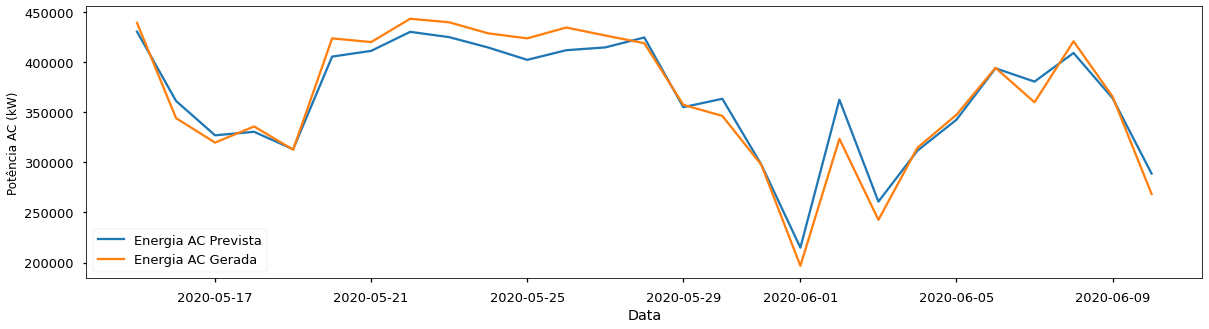

In [81]:
# Previsão da amostra de treino - MLP (Primeiros 27 dias)
previsoesPlot = treino_reshape.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesPlot['AC_POWER_FUTURO'] = previsaoTreinoNormalizadoInvertido_MLP

# Plotar gráfico
previsoesPlot['Data'] = previsoesPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesPlot = previsoesPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesPlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Prevista')

treinoPlot = treino_reshape.copy()
treinoPlot['Data'] = treinoPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
treinoPlot = treinoPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
treinoPlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Gerada')

plt.ylabel('Potência AC (kW)',fontsize=12)
plt.legend()
plt.show()

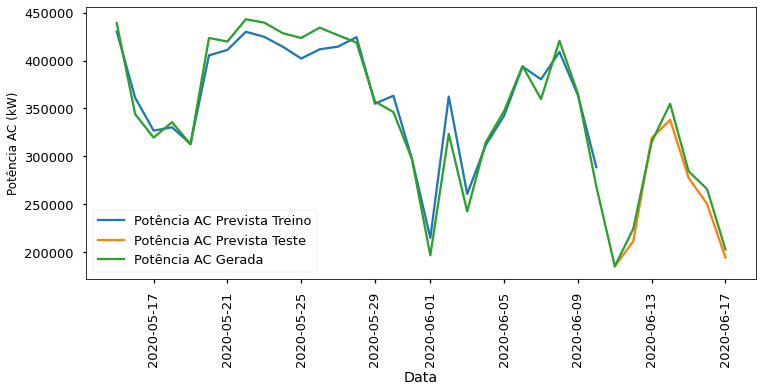

In [82]:
# Previsão da amostra completa - MLP
# Plotar gráfico previsão treino
previsoesTreinoPlot = treino_reshape.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesTreinoPlot['AC_POWER_FUTURO'] = previsaoTreinoNormalizadoInvertido_MLP

previsoesTreinoPlot['Data'] = previsoesTreinoPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesTreinoPlot = previsoesTreinoPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesTreinoPlot['AC_POWER_FUTURO'].plot(figsize=(12,5),label='Potência AC Prevista Treino')

# Plotar gráfico previsão teste
previsoesTestePlot = teste_reshape.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesTestePlot['AC_POWER_FUTURO'] = previsaoTesteNormalizadoInvertido_MLP

previsoesTestePlot['Data'] = previsoesTestePlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesTestePlot = previsoesTestePlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesTestePlot['AC_POWER_FUTURO'].plot(figsize=(12,5),label='Potência AC Prevista Teste')

# Plotar gráfico original
completoPlot = dtGeracaoEnergia.copy()
completoPlot['Data'] = completoPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
completoPlot = completoPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
completoPlot['AC_POWER_FUTURO'].plot(figsize=(12,5),label='Potência AC Gerada')

plt.ylabel('Potência AC (kW)',fontsize=12)
plt.xticks(rotation = 90)
plt.legend()
plt.savefig(diretorioImagens + '/' + nomeModelo + '_' + str(neuroniosMLP) + '_' + str(batchSizeMLP) + '_' + str(epocasMLP) + '_' + str(qtdCamadasMLP) + '_completa.png', format='png', bbox_inches='tight')
plt.show()

## 5.6 Erro RMSE

In [83]:
# Cálculo do RMSE para amostra teste
testScore_MLP = math.sqrt(mean_squared_error(np.array(teste_reshape['AC_POWER_FUTURO']), previsaoTesteNormalizadoInvertido_MLP))
print("O valor do RMSE para a amostra teste é: " + str(testScore_MLP))

# Cálculo do RMSE para amostra treino
treinoScore_MLP = math.sqrt(mean_squared_error(np.array(treino_reshape['AC_POWER_FUTURO']), previsaoTreinoNormalizadoInvertido_MLP))
print("O valor do RMSE para a amostra treino é: " + str(treinoScore_MLP))

# Cálculo do RMSE para amostra completa
completoScore_MLP = math.sqrt(mean_squared_error(np.array(completo_reshape['AC_POWER_FUTURO']), previsaoCompletoNormalizadoInvertido_MLP))
print("O valor do RMSE para a amostra completa é: " + str(completoScore_MLP))

O valor do RMSE para a amostra teste é: 121.64659885630674
O valor do RMSE para a amostra treino é: 149.06207682597153
O valor do RMSE para a amostra completa é: 143.83195837853089


# 6. Modelagem com MLP - Window

In [84]:
# Divide uma sequência com múltiplos atributos em duas amostras
def criar_amostra(sequencias, look_back):
    Entrada, saida = list(), list()
    for i in range(len(sequencias)):
        # Olha para trás de acordo com a quantidade de passos desejados
        end_ix = i + look_back
        # Verifica se existem dados para olhar para trás na amostra de entrada
        if end_ix > len(sequencias)-1:
            break
        # Separa a amostra de entrada em "Entrada" e "Saída"
        seq_x = sequencias[i:end_ix, :-1] # Coleta os valores de entrada
        seq_y = sequencias[end_ix - 1, -1] # Coleta os valores de saída futuros
        Entrada.append(seq_x)
        saida.append(seq_y)
    return np.array(Entrada), np.array(saida)

In [85]:
look_back = 48

treinoX_normalizado, treinoY_normalizado = criar_amostra(dataset_treino_normalizado, look_back)
testeX_normalizado, testeY_normalizado = criar_amostra(dataset_teste_normalizado, look_back)
completoX_normalizado, completoY_normalizado = criar_amostra(dataset_completo_normalizado, look_back)

# Imprimir primeira linha da entrada do dataset de treino
print(treinoX_normalizado[0:3])

# Imprimir primeira linha da saída do dataset de treino (Percebe-se que o primeiro item é o valor futuro da amostra completa)
print("\n", treinoY_normalizado[0:3])

[[[0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.03862096]
  [0.03862096]
  [0.03862096]
  [0.03862096]
  [0.03862096]
  [0.03862096]
  [0.03862096]
  [0.03862096]
  [0.03862096]
  [0.03862096]
  [0.03862096]
  [0.03862096]
  [0.09419283]
  [0.09419283]
  [0.09419283]
  [0.09419283]
  [0.09419283]
  [0.09419283]
  [0.09419283]
  [0.09419283]
  [0.09419283]
  [0.09419283]
  [0.09419283]
  [0.09419283]]

 [[0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.019

In [86]:
print(dataset_treino_normalizado[47])

[0.09419283 0.01771148]


In [87]:
# Formato dos dados de treino
print(treinoX_normalizado.shape, treinoY_normalizado.shape)

# Formato dos dados de teste
print(testeX_normalizado.shape, testeY_normalizado.shape)

# Formato dos dados da amostra compelta
print(completoX_normalizado.shape, completoY_normalizado.shape)

(16752, 48, 1) (16752,)
(4319, 48, 1) (4319,)
(21119, 48, 1) (21119,)


In [88]:
# Criando modelo MLP Window
# A rede possui camada visível com 1 entrada
# Camada oculta com 64 blocos MLP ou neurônios
# 1 camada de saída
# Função de ativação sigmoid padrão
# Tamanho de lote (batch size) igual a 32

# Com neuronios igual a 12 e batchsize igual a 1, activation igual a linear, o MLP apresentou um teste de 0,00407167, treino 0,0073679 e completo 0,0066878

nomeModelo = 'MLP_Window' + nomeEntrada

neuroniosMLP_Window = 64
batchSizeMLP_Window = 32
epocasMLP_Window = 200
qtdCamadasMLP_Window = 1
n_atribute = treinoX_normalizado.shape[2]

reset_random_seeds()

model_MLP_Window = Sequential()

# Camada oculta
#model_MLP_Window.add(Dense(neuroniosMLP_Window, input_dim = look_back, activation = 'relu')) # univariável
model_MLP_Window.add(Dense(neuroniosMLP_Window, input_shape = (look_back, n_atribute), activation = 'sigmoid'))
model_MLP_Window.add(Flatten())
# Camada de saída
model_MLP_Window.add(Dense(1))

# Compilação
model_MLP_Window.compile(loss = "mean_squared_error", optimizer = 'adam')
model_MLP_Window.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 48, 64)            128       
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3073      
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [89]:
# Reduz o platô, ou seja, percebe se o treinamento entrou em um ponto de cela
rlronp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Interrompe o treinamento quando não calcular nenhum progresso na validação definida para várias épocsa
early_stopping_MLP_Window = EarlyStopping(monitor='val_loss', mode='min', patience = 10, verbose=1, restore_best_weights = True)

# Checkpoint, salva os pontos de verificação do modelo em intervalos regulares durante o treinamento, por padrão no fim de cada época, além disso, com save_best_only, salva somente o melhor modelo
checkpoint_MLP_Window = ModelCheckpoint(diretorioModelos + '/' + nomeModelo + '_' + str(neuroniosMLP_Window) + '_' + str(batchSizeMLP_Window) + '_' + str(epocasMLP_Window) + '_' + str(qtdCamadasMLP_Window) + '.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [90]:
reset_random_seeds()

# Fit do modelo
# validation_split = 0,1 - seleciona 10% dos dados de treinamento para realizar a validação durante o treino, isto é necessário para avaliar o desempenho do modelo com dados novos, visto que 10%
# dos dados de treinamento não serão utilizados no treino mas sim para verificar se estão sendo previstos adequadamente, auxilia a perceber se o modelo está causando overfitting
# isto é utilizado também para a função save_best_only, onde somente o modelo com melhor desempenho será salvo
historico_MLP_Window = model_MLP_Window.fit(treinoX_normalizado, treinoY_normalizado, epochs = epocasMLP_Window, batch_size = batchSizeMLP_Window, verbose = 2, validation_split = 0.15,
                        callbacks = [rlronp, early_stopping_MLP_Window, checkpoint_MLP_Window])

# Salvar modelo
model_MLP_Window.save(diretorioModelos + '/' + nomeModelo + '_' + str(neuroniosMLP_Window) + '_' + str(batchSizeMLP_Window) + '_' + str(epocasMLP_Window) + '_' + str(qtdCamadasMLP_Window) + '.h5')

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.02953, saving model to /content/drive/MyDrive/TCC/Modelos/MLP_Window_64_32_200_1.h5
445/445 - 3s - loss: 0.0519 - val_loss: 0.0295 - lr: 0.0010 - 3s/epoch - 7ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.02953 to 0.02053, saving model to /content/drive/MyDrive/TCC/Modelos/MLP_Window_64_32_200_1.h5
445/445 - 8s - loss: 0.0171 - val_loss: 0.0205 - lr: 0.0010 - 8s/epoch - 19ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.02053
445/445 - 4s - loss: 0.0198 - val_loss: 0.0251 - lr: 0.0010 - 4s/epoch - 9ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.02053
445/445 - 6s - loss: 0.0186 - val_loss: 0.0253 - lr: 0.0010 - 6s/epoch - 13ms/step
Epoch 5/200

Epoch 5: val_loss improved from 0.02053 to 0.01741, saving model to /content/drive/MyDrive/TCC/Modelos/MLP_Window_64_32_200_1.h5
445/445 - 6s - loss: 0.0150 - val_loss: 0.0174 - lr: 5.0000e-04 - 6s/epoch - 13ms/step
Epoch 6/200

Epoch 6: val_loss improved f

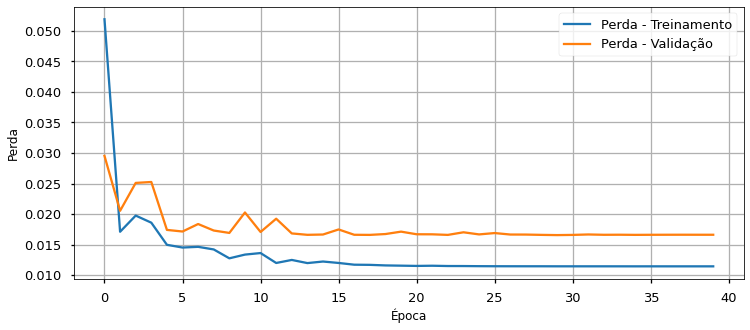

In [91]:
plt.figure(figsize=(12,5))
plt.plot(historico_MLP_Window.history['loss'], label = 'Perda - Treinamento')
plt.plot(historico_MLP_Window.history['val_loss'], label = 'Perda - Validação')
plt.grid()
plt.xlabel('Época',fontsize=12)
plt.ylabel('Perda',fontsize=12)
plt.legend()
plt.savefig(diretorioImagens + '/Perdas_' + nomeModelo + '_' + str(neuroniosMLP_Window) + '_' + str(batchSizeMLP_Window) + '_' + str(epocasMLP_Window) + '_' + str(qtdCamadasMLP_Window) + '.png', format='png', bbox_inches='tight')

## 6.1 Previsões

In [92]:
# Previsão da amostra de teste - MLP
previsaoTesteNormalizado_MLP_Window = model_MLP_Window.predict(testeX_normalizado)

# Previsão da amostra de treino - MLP
previsaoTreinoNormalizado_MLP_Window = model_MLP_Window.predict(treinoX_normalizado)

# Previsão da amostra completa - MLP
previsaoCompletoNormalizado_MLP_Window = model_MLP_Window.predict(completoX_normalizado)

In [93]:
# Formato dos dados previstos para teste
print(previsaoTesteNormalizado_MLP_Window.shape, teste.shape)

# Formato dos dados previstos para treino
print(previsaoTreinoNormalizado_MLP_Window.shape, treino.shape)

# Formato dos dados previstos para a amostra completa
print(previsaoCompletoNormalizado_MLP_Window.shape, dtGeracaoEnergia.shape)

(4319, 1) (4367, 9)
(16752, 1) (16800, 9)
(21119, 1) (21167, 9)


## 6.2 Erro MSE

In [94]:
desempenho_treino = mean_squared_error(treinoY_normalizado, previsaoTreinoNormalizado_MLP_Window)
print(f'Desempenho do treinamento: {desempenho_treino} MSE')

desempenho_teste = mean_squared_error(testeY_normalizado, previsaoTesteNormalizado_MLP_Window)
print(f'Desempenho do teste: {desempenho_teste} MSE')

desempenho_completo = mean_squared_error(completoY_normalizado, previsaoCompletoNormalizado_MLP_Window)
print(f'Desempenho da amostra completa: {desempenho_completo} MSE')

Desempenho do treinamento: 0.012227276824191282 MSE
Desempenho do teste: 0.00984704831038552 MSE
Desempenho da amostra completa: 0.011712697377175956 MSE


In [95]:
desempenho_treino_rmse = math.sqrt(mean_squared_error(treinoY_normalizado, previsaoTreinoNormalizado_MLP_Window))
print(f'Desempenho do treinamento: {desempenho_treino_rmse} RMSE')

desempenho_teste_rmse = math.sqrt(mean_squared_error(testeY_normalizado, previsaoTesteNormalizado_MLP_Window))
print(f'Desempenho do teste: {desempenho_teste_rmse} RMSE')

desempenho_completo_rmse = math.sqrt(mean_squared_error(completoY_normalizado, previsaoCompletoNormalizado_MLP_Window))
print(f'Desempenho da amostra completa: {desempenho_completo_rmse} RMSE')

Desempenho do treinamento: 0.11057701761302519 RMSE
Desempenho do teste: 0.09923229469474905 RMSE
Desempenho da amostra completa: 0.10822521599505337 RMSE


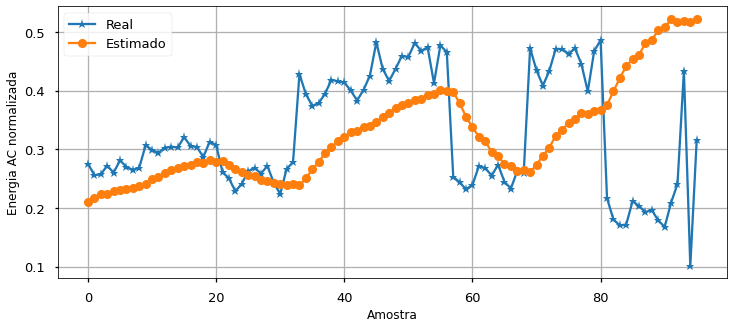

In [96]:
i=1779 - look_back
j=i+48*2
plt.figure(figsize=(12,5))
plt.plot(range(j-i), testeY_normalizado[i:j],'-*' ,range(j-i), previsaoTesteNormalizado_MLP_Window[i:j],'-o')
plt.legend(('Real','Estimado'))
plt.xlabel('Amostra',fontsize=12)
plt.ylabel('Energia AC normalizada',fontsize=12)
plt.savefig(diretorioImagens + '/Desempenho_Teste_' + nomeModelo + '.png', format='png', bbox_inches='tight')
plt.grid()
plt.show()

## 6.3 Preparando amostras reais

Para gerar o gráfico posteriormente será necessário remover uma linha de dado das amostras reais.

In [97]:
teste

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,HOUR,AC_POWER,AC_POWER_FUTURO
2592,2020-06-11 06:00:00,81aHJ1q11NBPMrL,24.265365,23.726226,0.004264,11,6,0.700000,0.685714
2593,2020-06-11 06:00:00,9kRcWv60rDACzjR,24.265365,23.726226,0.004264,11,6,0.685714,0.614286
2594,2020-06-11 06:00:00,LYwnQax7tkwH5Cb,24.265365,23.726226,0.004264,11,6,0.614286,0.000000
2595,2020-06-11 06:00:00,LlT2YUhhzqhg5Sw,24.265365,23.726226,0.004264,11,6,0.000000,0.573333
2596,2020-06-11 06:00:00,PeE6FRyGXUgsRhN,24.265365,23.726226,0.004264,11,6,0.573333,1.366667
...,...,...,...,...,...,...,...,...,...
21162,2020-06-17 17:45:00,WcxssY2VbP4hApt,26.091664,27.235657,0.065480,17,17,97.046667,96.620000
21163,2020-06-17 17:45:00,oZZkBaNadn6DNKz,26.091664,27.235657,0.065480,17,17,96.620000,94.700000
21164,2020-06-17 17:45:00,q49J1IKaHRwDQnt,26.091664,27.235657,0.065480,17,17,94.700000,89.680000
21165,2020-06-17 17:45:00,rrq4fwE8jgrTyWY,26.091664,27.235657,0.065480,17,17,89.680000,96.693333


In [98]:
# Removendo linhas da amostra real
teste_reshape = teste.copy()
treino_reshape = treino.copy()
completo_reshape = dtGeracaoEnergia.copy()

for i in range(look_back - 1):
    teste_reshape = teste_reshape.drop([teste.index[i]])
    treino_reshape = treino_reshape.drop([treino.index[i]])
    completo_reshape = completo_reshape.drop([dtGeracaoEnergia.index[i]])

teste_reshape = teste_reshape.drop([teste.index[-1]])
treino_reshape = treino_reshape.drop([treino.index[-1]])
completo_reshape = completo_reshape.drop([dtGeracaoEnergia.index[-1]])

In [99]:
# Invertendo normalização das amostras reais para comparar e verificar se as data tables foram corretamente filtradas
scale = MinMaxScaler()
scale.min_, scale.scale_ = scaler_com_dados_treino.min_[treinoX_normalizado.shape[2]], scaler_com_dados_treino.scale_[treinoX_normalizado.shape[2]]

# Para amostra real teste
testeY_invertido =  scale.inverse_transform(testeY_normalizado.reshape(-1,1))

# Para amostra real teste
treinoY_invertido =  scale.inverse_transform(treinoY_normalizado.reshape(-1,1))

# Para amostra real teste
completoY_invertido =  scale.inverse_transform(completoY_normalizado.reshape(-1,1))

In [100]:
# Amostra real não normalizada utilizada para comparar com os dados previstos
print(testeY_invertido)

[[70.10714286]
 [69.19285714]
 [66.2       ]
 ...
 [94.7       ]
 [89.68      ]
 [96.69333333]]


In [101]:
teste_reshape

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,HOUR,AC_POWER,AC_POWER_FUTURO
2639,2020-06-11 06:45:00,xoJJ8DcxJEcupym,24.227979,23.938855,0.022495,11,6,33.235714,70.107143
2640,2020-06-11 18:00:00,81aHJ1q11NBPMrL,26.725963,26.888934,0.046955,11,18,70.107143,69.192857
2641,2020-06-11 18:00:00,9kRcWv60rDACzjR,26.725963,26.888934,0.046955,11,18,69.192857,66.200000
2642,2020-06-11 18:00:00,LYwnQax7tkwH5Cb,26.725963,26.888934,0.046955,11,18,66.200000,67.850000
2643,2020-06-11 18:00:00,LlT2YUhhzqhg5Sw,26.725963,26.888934,0.046955,11,18,67.850000,69.586667
...,...,...,...,...,...,...,...,...,...
21161,2020-06-17 17:45:00,V94E5Ben1TlhnDV,26.091664,27.235657,0.065480,17,17,95.106667,97.046667
21162,2020-06-17 17:45:00,WcxssY2VbP4hApt,26.091664,27.235657,0.065480,17,17,97.046667,96.620000
21163,2020-06-17 17:45:00,oZZkBaNadn6DNKz,26.091664,27.235657,0.065480,17,17,96.620000,94.700000
21164,2020-06-17 17:45:00,q49J1IKaHRwDQnt,26.091664,27.235657,0.065480,17,17,94.700000,89.680000


In [102]:
# Amostra real não normalizada utilizada para comparar com os dados previstos
print(treinoY_invertido)

[[24.42      ]
 [24.41333333]
 [23.56      ]
 ...
 [13.6       ]
 [14.47142857]
 [13.55714286]]


In [103]:
treino_reshape

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,HOUR,AC_POWER,AC_POWER_FUTURO
47,2020-05-15 06:45:00,xoJJ8DcxJEcupym,25.048245,25.746662,0.103496,15,6,144.166667,24.420000
48,2020-05-15 18:00:00,81aHJ1q11NBPMrL,34.367762,33.148010,0.017895,15,18,24.420000,24.413333
49,2020-05-15 18:00:00,9kRcWv60rDACzjR,34.367762,33.148010,0.017895,15,18,24.413333,23.560000
50,2020-05-15 18:00:00,LYwnQax7tkwH5Cb,34.367762,33.148010,0.017895,15,18,23.560000,23.873333
51,2020-05-15 18:00:00,LlT2YUhhzqhg5Sw,34.367762,33.148010,0.017895,15,18,23.873333,23.140000
...,...,...,...,...,...,...,...,...,...
17466,2020-06-10 17:45:00,WcxssY2VbP4hApt,27.759774,25.464606,0.007683,10,17,14.264286,13.207143
17467,2020-06-10 17:45:00,oZZkBaNadn6DNKz,27.759774,25.464606,0.007683,10,17,13.207143,14.257143
17468,2020-06-10 17:45:00,q49J1IKaHRwDQnt,27.759774,25.464606,0.007683,10,17,14.257143,13.600000
17469,2020-06-10 17:45:00,rrq4fwE8jgrTyWY,27.759774,25.464606,0.007683,10,17,13.600000,14.471429


In [104]:
# Amostra real não normalizada utilizada para comparar com os dados previstos
print(completoY_invertido)

[[24.42      ]
 [24.41333333]
 [23.56      ]
 ...
 [94.7       ]
 [89.68      ]
 [96.69333333]]


In [105]:
completo_reshape

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,HOUR,AC_POWER,AC_POWER_FUTURO
47,2020-05-15 06:45:00,xoJJ8DcxJEcupym,25.048245,25.746662,0.103496,15,6,144.166667,24.420000
48,2020-05-15 18:00:00,81aHJ1q11NBPMrL,34.367762,33.148010,0.017895,15,18,24.420000,24.413333
49,2020-05-15 18:00:00,9kRcWv60rDACzjR,34.367762,33.148010,0.017895,15,18,24.413333,23.560000
50,2020-05-15 18:00:00,LYwnQax7tkwH5Cb,34.367762,33.148010,0.017895,15,18,23.560000,23.873333
51,2020-05-15 18:00:00,LlT2YUhhzqhg5Sw,34.367762,33.148010,0.017895,15,18,23.873333,23.140000
...,...,...,...,...,...,...,...,...,...
21161,2020-06-17 17:45:00,V94E5Ben1TlhnDV,26.091664,27.235657,0.065480,17,17,95.106667,97.046667
21162,2020-06-17 17:45:00,WcxssY2VbP4hApt,26.091664,27.235657,0.065480,17,17,97.046667,96.620000
21163,2020-06-17 17:45:00,oZZkBaNadn6DNKz,26.091664,27.235657,0.065480,17,17,96.620000,94.700000
21164,2020-06-17 17:45:00,q49J1IKaHRwDQnt,26.091664,27.235657,0.065480,17,17,94.700000,89.680000


In [106]:
# Comparação entre os formatos da previsão e dos dados para plotar o gráfico real
print(previsaoTesteNormalizado_MLP_Window.shape, teste_reshape.shape)

# Comparação entre os formatos da previsão e dos dados para plotar o gráfico real
print(previsaoTreinoNormalizado_MLP_Window.shape, treino_reshape.shape)

# Comparação entre os formatos da previsão e dos dados para plotar o gráfico real
print(previsaoCompletoNormalizado_MLP_Window.shape, completo_reshape.shape)

(4319, 1) (4319, 9)
(16752, 1) (16752, 9)
(21119, 1) (21119, 9)


## 6.4 Invertendo Normalização

In [107]:
# Imprime valores minímos e máximos
# min_ = min - X.min(axis=0) * self.scale_
# scale_ = (max - min) / (X.max(axis=0) - X.min(axis=0))
# data_min_ = valor mínimo na amostra
# data_max_ = valor máximo na amostra
scaler_com_dados_treino.min_, scaler_com_dados_treino.scale_, scaler_com_dados_treino.data_min_, scaler_com_dados_treino.data_max_

(array([0., 0.]),
 array([9.10111853e-01, 7.25285884e-04]),
 array([0., 0.]),
 array([1.09876604e+00, 1.37876667e+03]))

In [108]:
# Invertendo normalização para interpretação dos resultados
scale = MinMaxScaler()
scale.min_, scale.scale_ = scaler_com_dados_treino.min_[treinoX_normalizado.shape[2]], scaler_com_dados_treino.scale_[treinoX_normalizado.shape[2]]

# Para amostra de teste
previsaoTesteNormalizadoInvertido_MLP_Window = scale.inverse_transform(previsaoTesteNormalizado_MLP_Window) # Inverte normalização para os valores previstos de teste

# Para amostra de treino
previsaoTreinoNormalizadoInvertido_MLP_Window = scale.inverse_transform(previsaoTreinoNormalizado_MLP_Window)

# Para amostra completa
previsaoCompletoNormalizadoInvertido_MLP_Window = scale.inverse_transform(previsaoCompletoNormalizado_MLP_Window)

## 6.5 Resultado das Previsões

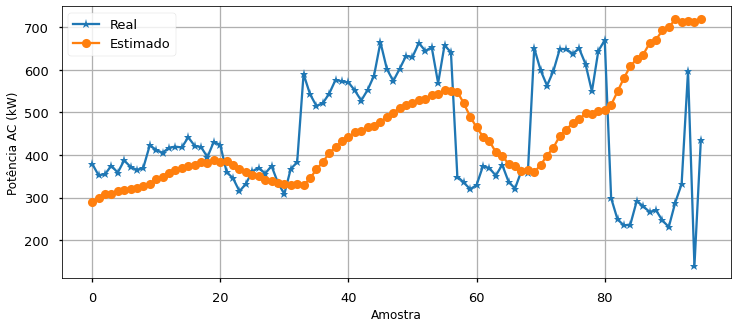

In [109]:
i=1779 - look_back
j=i+48*2
plt.figure(figsize=(12,5))
plt.plot(range(j-i), np.array(teste_reshape['AC_POWER_FUTURO'][i:j]),'-*' ,range(j-i), previsaoTesteNormalizadoInvertido_MLP_Window[i:j],'-o')
plt.legend(('Real','Estimado'))
plt.xlabel('Amostra',fontsize=12)
plt.ylabel('Potência AC (kW)',fontsize=12)
plt.savefig(diretorioImagens + '/Desempenho_Teste_Invertido' + nomeModelo + '.png', format='png', bbox_inches='tight')
plt.grid()
plt.show()

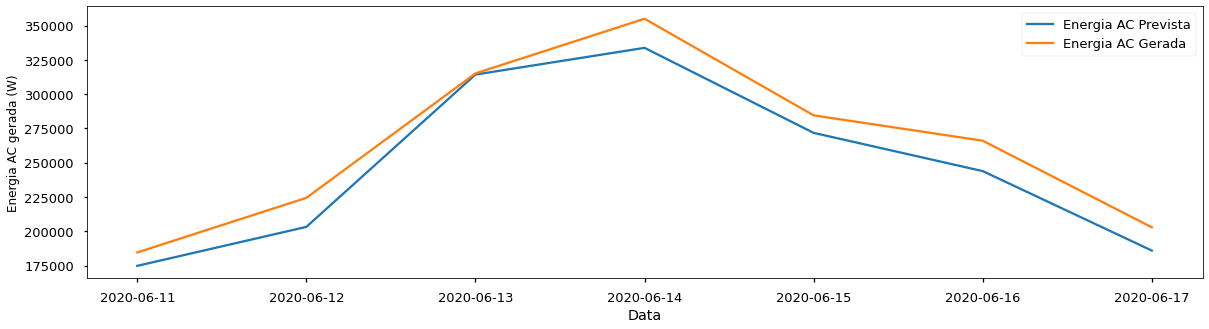

In [110]:
# Previsão da amostra de teste - MLP Window (Últimos 10 dias)
previsoesPlot = teste_reshape.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesPlot['AC_POWER_FUTURO'] = previsaoTesteNormalizadoInvertido_MLP_Window

# Plotar gráfico
previsoesPlot['Data'] = previsoesPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesPlot = previsoesPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesPlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Prevista')

testePlot = teste_reshape.copy()
testePlot['Data'] = testePlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
testePlot = testePlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
testePlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Gerada')

plt.ylabel('Energia AC gerada (W)',fontsize=12)
plt.legend()
plt.show()

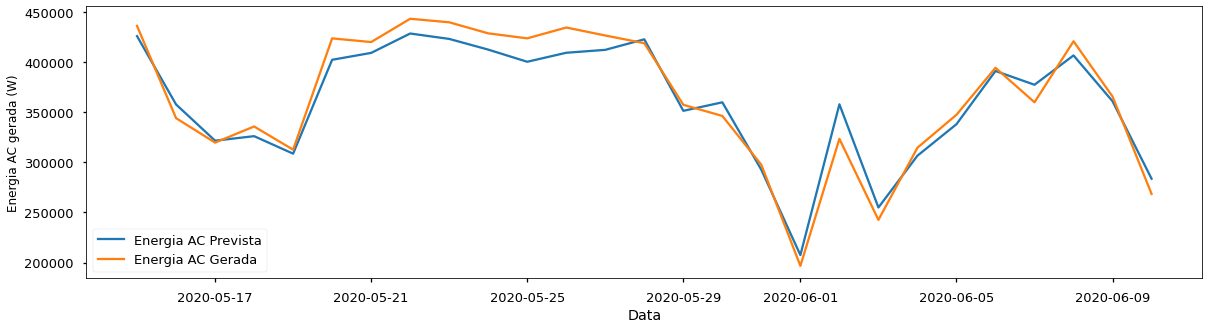

In [111]:
# Previsão da amostra de treino - MLP Window (Primeiros 27 dias)
previsoesPlot = treino_reshape.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesPlot['AC_POWER_FUTURO'] = previsaoTreinoNormalizadoInvertido_MLP_Window

# Plotar gráfico
previsoesPlot['Data'] = previsoesPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesPlot = previsoesPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesPlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Prevista')

treinoPlot = treino_reshape.copy()
treinoPlot['Data'] = treinoPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
treinoPlot = treinoPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
treinoPlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Gerada')

plt.ylabel('Energia AC gerada (W)',fontsize=12)
plt.legend()
plt.show()

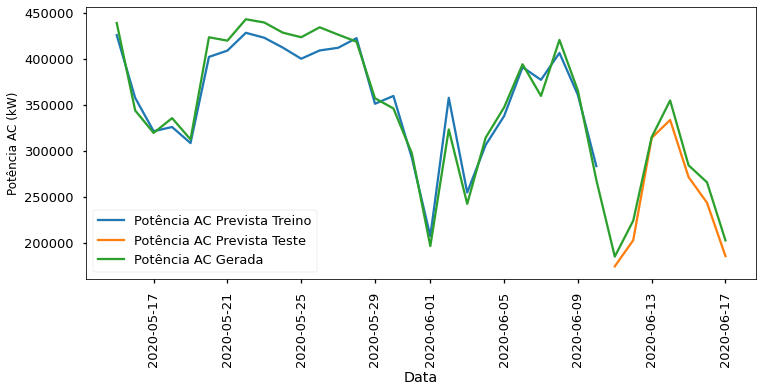

In [112]:
# Previsão da amostra completa - MLP Window
# Plotar gráfico previsão treino
previsoesTreinoPlot = treino_reshape.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesTreinoPlot['AC_POWER_FUTURO'] = previsaoTreinoNormalizadoInvertido_MLP_Window

previsoesTreinoPlot['Data'] = previsoesTreinoPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesTreinoPlot = previsoesTreinoPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesTreinoPlot['AC_POWER_FUTURO'].plot(figsize=(12,5),label='Potência AC Prevista Treino')

# Plotar gráfico previsão teste
previsoesTestePlot = teste_reshape.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesTestePlot['AC_POWER_FUTURO'] = previsaoTesteNormalizadoInvertido_MLP_Window

previsoesTestePlot['Data'] = previsoesTestePlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesTestePlot = previsoesTestePlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesTestePlot['AC_POWER_FUTURO'].plot(figsize=(12,5),label='Potência AC Prevista Teste')

# Plotar gráfico original
completoPlot = dtGeracaoEnergia.copy()
completoPlot['Data'] = completoPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
completoPlot = completoPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
completoPlot['AC_POWER_FUTURO'].plot(figsize=(12,5),label='Potência AC Gerada')

plt.ylabel('Potência AC (kW)',fontsize=12)
plt.xticks(rotation = 90)
plt.legend()
plt.savefig(diretorioImagens + '/' + nomeModelo + '_' + str(neuroniosMLP_Window) + '_' + str(batchSizeMLP_Window) + '_' + str(epocasMLP_Window) + '_' + str(qtdCamadasMLP_Window) + '_completa.png', format='png', bbox_inches='tight')
plt.show()

## 6.6 Erro RMSE

In [113]:
# Cálculo do RMSE para amostra teste
testScore_MLP_Window = math.sqrt(mean_squared_error(np.array(teste_reshape['AC_POWER_FUTURO']), previsaoTesteNormalizadoInvertido_MLP_Window))
print("O valor do RMSE para a amostra teste é: " + str(testScore_MLP_Window))

# Cálculo do RMSE para amostra treino
treinoScore_MLP_Window = math.sqrt(mean_squared_error(np.array(treino_reshape['AC_POWER_FUTURO']), previsaoTreinoNormalizadoInvertido_MLP_Window))
print("O valor do RMSE para a amostra treino é: " + str(treinoScore_MLP_Window))

# Cálculo do RMSE para amostra completa
completoScore_MLP_Window = math.sqrt(mean_squared_error(np.array(completo_reshape['AC_POWER_FUTURO']), previsaoCompletoNormalizadoInvertido_MLP_Window))
print("O valor do RMSE para a amostra completa é: " + str(completoScore_MLP_Window))

O valor do RMSE para a amostra teste é: 136.81818246168658
O valor do RMSE para a amostra treino é: 152.45990621986354
O valor do RMSE para a amostra completa é: 149.2173209228093


# 7. Modelagem com LSTM - Vanilla

In [114]:
# Divide uma sequência com múltiplos atributos em duas amostras
def criar_amostra(sequencias, look_back):
    Entrada, saida = list(), list()
    for i in range(len(sequencias)):
        # Olha para trás de acordo com a quantidade de passos desejados
        end_ix = i + look_back
        # Verifica se existem dados para olhar para trás na amostra de entrada
        if end_ix > len(sequencias)-1:
            break
        # Separa a amostra de entrada em "Entrada" e "Saída"
        seq_x = sequencias[i:end_ix, :-1] # Coleta os valores de entrada
        seq_y = sequencias[end_ix - 1, -1] # Coleta os valores de saída futuros
        Entrada.append(seq_x)
        saida.append(seq_y)
    return np.array(Entrada), np.array(saida)

In [115]:
look_back = 1

treinoX_normalizado, treinoY_normalizado = criar_amostra(dataset_treino_normalizado, look_back)
testeX_normalizado, testeY_normalizado = criar_amostra(dataset_teste_normalizado, look_back)
completoX_normalizado, completoY_normalizado = criar_amostra(dataset_completo_normalizado, look_back)

# Imprimir primeira linha da entrada do dataset de treino
print(treinoX_normalizado[0:3])

# Imprimir primeira linha da saída do dataset de treino (Percebe-se que o primeiro item é o valor futuro da amostra completa)
print("\n", treinoY_normalizado[0:3])

[[[0.01179685]]

 [[0.01179685]]

 [[0.01179685]]]

 [0.01076324 0.01089379 0.01064236]


In [116]:
print(dataset_treino_normalizado[0:3])

[[0.01179685 0.01076324]
 [0.01179685 0.01089379]
 [0.01179685 0.01064236]]


In [117]:
# Formato dos dados de treino
print(treinoX_normalizado.shape, treinoY_normalizado.shape)

# Formato dos dados de teste
print(testeX_normalizado.shape, testeY_normalizado.shape)

# Formato dos dados da amostra compelta
print(completoX_normalizado.shape, completoY_normalizado.shape)

(16799, 1, 1) (16799,)
(4366, 1, 1) (4366,)
(21166, 1, 1) (21166,)


In [118]:
# Criando modelo LSTM
# A rede possui camada visível com 1 entrada
# Camada oculta com 64 blocos LSTM ou neurônios
# 1 camada de saída
# Função de ativação sigmoide padrão
# Tamanho de lote (batch size) igual a 32

nomeModelo = 'LSTM_Vanilla' + nomeEntrada

# Coleta o número de atributos da amostra criada
n_atributos = treinoX_normalizado.shape[2]

neuroniosLSTM = 64
batchSizeLSTM = 32
epocasLSTM = 200
qtdCamadasLSTM = 1

reset_random_seeds()

model_LSTM = Sequential()
model_LSTM.add(layers.LSTM(neuroniosLSTM, activation = 'sigmoid', input_shape = (look_back, n_atributos)))
model_LSTM.add(layers.Dense(1)) # camada de saída
model_LSTM.compile(loss = "mean_squared_error", optimizer = 'adam')
model_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [119]:
# Reduz o platô, ou seja, percebe se o treinamento entrou em um ponto de cela
rlronp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Interrompe o treinamento quando não calcular nenhum progresso na validação definida para várias épocsa
early_stopping_LSTM = EarlyStopping(monitor='val_loss', mode='min', patience = 10, verbose=1, restore_best_weights = True)

# Checkpoint, salva os pontos de verificação do modelo em intervalos regulares durante o treinamento, por padrão no fim de cada época, além disso, com save_best_only, salva somente o melhor modelo
checkpoint_LSTM = ModelCheckpoint(diretorioModelos + '/' + nomeModelo + '_' + str(neuroniosLSTM) + '_' + str(batchSizeLSTM) + '_' + str(epocasLSTM) + '_' + str(qtdCamadasLSTM) + '.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [120]:
reset_random_seeds()

# Fit do modelo
# validation_split = 0,1 - seleciona 10% dos dados de treinamento para realizar a validação durante o treino, isto é necessário para avaliar o desempenho do modelo com dados novos, visto que 10%
# dos dados de treinamento não serão utilizados no treino mas sim para verificar se estão sendo previstos adequadamente, auxilia a perceber se o modelo está causando overfitting
# isto é utilizado também para a função save_best_only, onde somente o modelo com melhor desempenho será salvo
historico_LSTM = model_LSTM.fit(treinoX_normalizado, treinoY_normalizado, epochs = epocasLSTM, batch_size = batchSizeLSTM, verbose = 2, validation_split = 0.15,
                        callbacks = [rlronp, early_stopping_LSTM, checkpoint_LSTM])

# Salvar modelo
model_LSTM.save(diretorioModelos + '/' + nomeModelo + '_' + str(neuroniosLSTM) + '_' + str(batchSizeLSTM) + '_' + str(epocasLSTM) + '_' + str(qtdCamadasLSTM) + '.h5')

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.03070, saving model to /content/drive/MyDrive/TCC/Modelos/LSTM_Vanilla_64_32_200_1.h5
447/447 - 3s - loss: 0.0843 - val_loss: 0.0307 - lr: 0.0010 - 3s/epoch - 6ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.03070 to 0.01547, saving model to /content/drive/MyDrive/TCC/Modelos/LSTM_Vanilla_64_32_200_1.h5
447/447 - 1s - loss: 0.0220 - val_loss: 0.0155 - lr: 0.0010 - 1s/epoch - 2ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.01547 to 0.01514, saving model to /content/drive/MyDrive/TCC/Modelos/LSTM_Vanilla_64_32_200_1.h5
447/447 - 1s - loss: 0.0115 - val_loss: 0.0151 - lr: 0.0010 - 1s/epoch - 2ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.01514
447/447 - 1s - loss: 0.0112 - val_loss: 0.0158 - lr: 0.0010 - 992ms/epoch - 2ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.01514
447/447 - 1s - loss: 0.0112 - val_loss: 0.0152 - lr: 0.0010 - 1s/epoch - 2ms/step
Epoch 6/200

Epoch 6: val_loss did not 

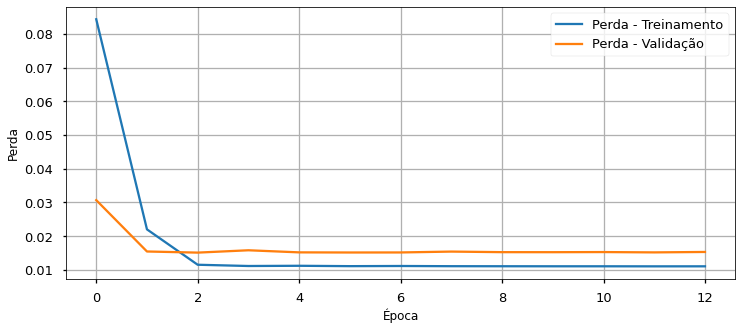

In [121]:
plt.figure(figsize=(12,5))
plt.grid()
plt.plot(historico_LSTM.history['loss'], label = 'Perda - Treinamento')
plt.plot(historico_LSTM.history['val_loss'], label = 'Perda - Validação')
plt.xlabel('Época',fontsize=12)
plt.ylabel('Perda',fontsize=12)
plt.legend()
plt.savefig(diretorioImagens + '/Perdas_' + nomeModelo + '_' + str(neuroniosLSTM) + '_' + str(batchSizeLSTM) + '_' + str(epocasLSTM) + '_' + str(qtdCamadasLSTM) + '.png', format='png', bbox_inches='tight')

## 7.1 Previsões

In [122]:
# Previsão da amostra de teste - LSTM
previsaoTesteNormalizado_LSTM = model_LSTM.predict(testeX_normalizado)

# Previsão da amostra de treino - LSTM
previsaoTreinoNormalizado_LSTM = model_LSTM.predict(treinoX_normalizado)

# Previsão da amostra completa - LSTM
previsaoCompletoNormalizado_LSTM = model_LSTM.predict(completoX_normalizado)

In [123]:
# Formato dos dados previstos para teste
print(previsaoTesteNormalizado_LSTM.shape, teste.shape)

# Formato dos dados previstos para treino
print(previsaoTreinoNormalizado_LSTM.shape, treino.shape)

# Formato dos dados previstos para a amostra completa
print(previsaoCompletoNormalizado_LSTM.shape, dtGeracaoEnergia.shape)

(4366, 1) (4367, 9)
(16799, 1) (16800, 9)
(21166, 1) (21167, 9)


## 7.2 Erro MSE

In [124]:
desempenho_treino = mean_squared_error(treinoY_normalizado, previsaoTreinoNormalizado_LSTM)
print(f'Desempenho do treinamento: {desempenho_treino} MSE')

desempenho_teste = mean_squared_error(testeY_normalizado, previsaoTesteNormalizado_LSTM)
print(f'Desempenho do teste: {desempenho_teste} MSE')

desempenho_completo = mean_squared_error(completoY_normalizado, previsaoCompletoNormalizado_LSTM)
print(f'Desempenho da amostra completa: {desempenho_completo} MSE')

Desempenho do treinamento: 0.01169259172922185 MSE
Desempenho do teste: 0.007802859573155985 MSE
Desempenho da amostra completa: 0.010889727091657486 MSE


In [125]:
desempenho_treino_rmse = math.sqrt(mean_squared_error(treinoY_normalizado, previsaoTreinoNormalizado_LSTM))
print(f'Desempenho do treinamento: {desempenho_treino_rmse} RMSE')

desempenho_teste_rmse = math.sqrt(mean_squared_error(testeY_normalizado, previsaoTesteNormalizado_LSTM))
print(f'Desempenho do teste: {desempenho_teste_rmse} RMSE')

desempenho_completo_rmse = math.sqrt(mean_squared_error(completoY_normalizado, previsaoCompletoNormalizado_LSTM))
print(f'Desempenho da amostra completa: {desempenho_completo_rmse} RMSE')

Desempenho do treinamento: 0.10813228809759762 RMSE
Desempenho do teste: 0.0883337963248268 RMSE
Desempenho da amostra completa: 0.10435385518349327 RMSE


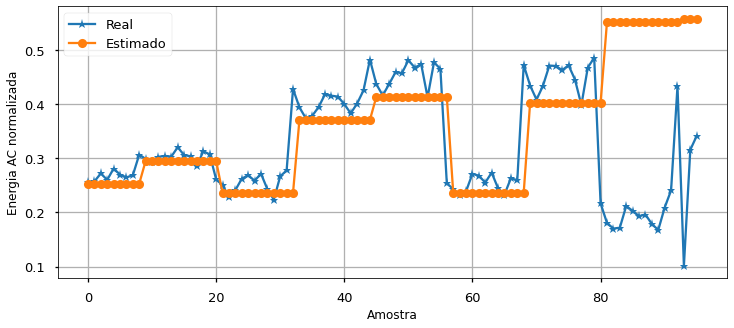

In [126]:
i=1779
j=i+48*2
plt.figure(figsize=(12,5))
plt.plot(range(j-i), testeY_normalizado[i:j],'-*' ,range(j-i), previsaoTesteNormalizado_LSTM[i:j],'-o')
plt.legend(('Real','Estimado'))
plt.xlabel('Amostra',fontsize=12)
plt.ylabel('Energia AC normalizada',fontsize=12)
plt.savefig(diretorioImagens + '/Desempenho_Teste_' + nomeModelo + '.png', format='png', bbox_inches='tight')
plt.grid()
plt.show()

## 7.3 Preparando amostras reais

Para gerar o gráfico posteriormente será necessário remover uma linha de dado das amostras reais.

In [127]:
teste

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,HOUR,AC_POWER,AC_POWER_FUTURO
2592,2020-06-11 06:00:00,81aHJ1q11NBPMrL,24.265365,23.726226,0.004264,11,6,0.700000,0.685714
2593,2020-06-11 06:00:00,9kRcWv60rDACzjR,24.265365,23.726226,0.004264,11,6,0.685714,0.614286
2594,2020-06-11 06:00:00,LYwnQax7tkwH5Cb,24.265365,23.726226,0.004264,11,6,0.614286,0.000000
2595,2020-06-11 06:00:00,LlT2YUhhzqhg5Sw,24.265365,23.726226,0.004264,11,6,0.000000,0.573333
2596,2020-06-11 06:00:00,PeE6FRyGXUgsRhN,24.265365,23.726226,0.004264,11,6,0.573333,1.366667
...,...,...,...,...,...,...,...,...,...
21162,2020-06-17 17:45:00,WcxssY2VbP4hApt,26.091664,27.235657,0.065480,17,17,97.046667,96.620000
21163,2020-06-17 17:45:00,oZZkBaNadn6DNKz,26.091664,27.235657,0.065480,17,17,96.620000,94.700000
21164,2020-06-17 17:45:00,q49J1IKaHRwDQnt,26.091664,27.235657,0.065480,17,17,94.700000,89.680000
21165,2020-06-17 17:45:00,rrq4fwE8jgrTyWY,26.091664,27.235657,0.065480,17,17,89.680000,96.693333


In [128]:
from matplotlib.cbook import local_over_kwdict

# Removendo linhas da amostra real
teste_reshape = teste.copy()
treino_reshape = treino.copy()
completo_reshape = dtGeracaoEnergia.copy()

for i in range(look_back - 1):
    teste_reshape = teste_reshape.drop([teste.index[i]])
    treino_reshape = treino_reshape.drop([treino.index[i]])
    completo_reshape = completo_reshape.drop([dtGeracaoEnergia.index[i]])

teste_reshape = teste_reshape.drop([teste.index[-1]])
treino_reshape = treino_reshape.drop([treino.index[-1]])
completo_reshape = completo_reshape.drop([dtGeracaoEnergia.index[-1]])

In [129]:
# Invertendo normalização das amostras reais para comparar e verificar se as data tables foram corretamente filtradas
scale = MinMaxScaler()
scale.min_, scale.scale_ = scaler_com_dados_treino.min_[treinoX_normalizado.shape[2]], scaler_com_dados_treino.scale_[treinoX_normalizado.shape[2]]

# Para amostra real teste
testeY_invertido =  scale.inverse_transform(testeY_normalizado.reshape(-1,1))

# Para amostra real teste
treinoY_invertido =  scale.inverse_transform(treinoY_normalizado.reshape(-1,1))

# Para amostra real teste
completoY_invertido =  scale.inverse_transform(completoY_normalizado.reshape(-1,1))

In [130]:
# Amostra real não normalizada utilizada para comparar com os dados previstos
print(testeY_invertido)

[[ 0.68571429]
 [ 0.61428571]
 [ 0.        ]
 ...
 [94.7       ]
 [89.68      ]
 [96.69333333]]


In [131]:
teste_reshape

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,HOUR,AC_POWER,AC_POWER_FUTURO
2592,2020-06-11 06:00:00,81aHJ1q11NBPMrL,24.265365,23.726226,0.004264,11,6,0.700000,0.685714
2593,2020-06-11 06:00:00,9kRcWv60rDACzjR,24.265365,23.726226,0.004264,11,6,0.685714,0.614286
2594,2020-06-11 06:00:00,LYwnQax7tkwH5Cb,24.265365,23.726226,0.004264,11,6,0.614286,0.000000
2595,2020-06-11 06:00:00,LlT2YUhhzqhg5Sw,24.265365,23.726226,0.004264,11,6,0.000000,0.573333
2596,2020-06-11 06:00:00,PeE6FRyGXUgsRhN,24.265365,23.726226,0.004264,11,6,0.573333,1.366667
...,...,...,...,...,...,...,...,...,...
21161,2020-06-17 17:45:00,V94E5Ben1TlhnDV,26.091664,27.235657,0.065480,17,17,95.106667,97.046667
21162,2020-06-17 17:45:00,WcxssY2VbP4hApt,26.091664,27.235657,0.065480,17,17,97.046667,96.620000
21163,2020-06-17 17:45:00,oZZkBaNadn6DNKz,26.091664,27.235657,0.065480,17,17,96.620000,94.700000
21164,2020-06-17 17:45:00,q49J1IKaHRwDQnt,26.091664,27.235657,0.065480,17,17,94.700000,89.680000


In [132]:
# Amostra real não normalizada utilizada para comparar com os dados previstos
print(treinoY_invertido)

[[14.84      ]
 [15.02      ]
 [14.67333333]
 ...
 [13.6       ]
 [14.47142857]
 [13.55714286]]


In [133]:
treino_reshape

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,HOUR,AC_POWER,AC_POWER_FUTURO
0,2020-05-15 06:00:00,81aHJ1q11NBPMrL,24.742787,24.077230,0.012962,15,6,14.246667,14.840000
1,2020-05-15 06:00:00,9kRcWv60rDACzjR,24.742787,24.077230,0.012962,15,6,14.840000,15.020000
2,2020-05-15 06:00:00,LYwnQax7tkwH5Cb,24.742787,24.077230,0.012962,15,6,15.020000,14.673333
3,2020-05-15 06:00:00,LlT2YUhhzqhg5Sw,24.742787,24.077230,0.012962,15,6,14.673333,13.993333
4,2020-05-15 06:00:00,PeE6FRyGXUgsRhN,24.742787,24.077230,0.012962,15,6,13.993333,14.680000
...,...,...,...,...,...,...,...,...,...
17466,2020-06-10 17:45:00,WcxssY2VbP4hApt,27.759774,25.464606,0.007683,10,17,14.264286,13.207143
17467,2020-06-10 17:45:00,oZZkBaNadn6DNKz,27.759774,25.464606,0.007683,10,17,13.207143,14.257143
17468,2020-06-10 17:45:00,q49J1IKaHRwDQnt,27.759774,25.464606,0.007683,10,17,14.257143,13.600000
17469,2020-06-10 17:45:00,rrq4fwE8jgrTyWY,27.759774,25.464606,0.007683,10,17,13.600000,14.471429


In [134]:
# Amostra real não normalizada utilizada para comparar com os dados previstos
print(completoY_invertido)

[[14.84      ]
 [15.02      ]
 [14.67333333]
 ...
 [94.7       ]
 [89.68      ]
 [96.69333333]]


In [135]:
completo_reshape

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,HOUR,AC_POWER,AC_POWER_FUTURO
0,2020-05-15 06:00:00,81aHJ1q11NBPMrL,24.742787,24.077230,0.012962,15,6,14.246667,14.840000
1,2020-05-15 06:00:00,9kRcWv60rDACzjR,24.742787,24.077230,0.012962,15,6,14.840000,15.020000
2,2020-05-15 06:00:00,LYwnQax7tkwH5Cb,24.742787,24.077230,0.012962,15,6,15.020000,14.673333
3,2020-05-15 06:00:00,LlT2YUhhzqhg5Sw,24.742787,24.077230,0.012962,15,6,14.673333,13.993333
4,2020-05-15 06:00:00,PeE6FRyGXUgsRhN,24.742787,24.077230,0.012962,15,6,13.993333,14.680000
...,...,...,...,...,...,...,...,...,...
21161,2020-06-17 17:45:00,V94E5Ben1TlhnDV,26.091664,27.235657,0.065480,17,17,95.106667,97.046667
21162,2020-06-17 17:45:00,WcxssY2VbP4hApt,26.091664,27.235657,0.065480,17,17,97.046667,96.620000
21163,2020-06-17 17:45:00,oZZkBaNadn6DNKz,26.091664,27.235657,0.065480,17,17,96.620000,94.700000
21164,2020-06-17 17:45:00,q49J1IKaHRwDQnt,26.091664,27.235657,0.065480,17,17,94.700000,89.680000


In [136]:
# Comparação entre os formatos da previsão e dos dados para plotar o gráfico real
print(previsaoTesteNormalizado_LSTM.shape, teste_reshape.shape)

# Comparação entre os formatos da previsão e dos dados para plotar o gráfico real
print(previsaoTreinoNormalizado_LSTM.shape, treino_reshape.shape)

# Comparação entre os formatos da previsão e dos dados para plotar o gráfico real
print(previsaoCompletoNormalizado_LSTM.shape, completo_reshape.shape)

(4366, 1) (4366, 9)
(16799, 1) (16799, 9)
(21166, 1) (21166, 9)


## 7.4 Invertendo Normalização

In [137]:
# Imprime valores minímos e máximos
# min_ = min - X.min(axis=0) * self.scale_
# scale_ = (max - min) / (X.max(axis=0) - X.min(axis=0))
# data_min_ = valor mínimo na amostra
# data_max_ = valor máximo na amostra
scaler_com_dados_treino.min_, scaler_com_dados_treino.scale_, scaler_com_dados_treino.data_min_, scaler_com_dados_treino.data_max_

(array([0., 0.]),
 array([9.10111853e-01, 7.25285884e-04]),
 array([0., 0.]),
 array([1.09876604e+00, 1.37876667e+03]))

In [138]:
# Invertendo normalização para interpretação dos resultados
scale = MinMaxScaler()
scale.min_, scale.scale_ = scaler_com_dados_treino.min_[treinoX_normalizado.shape[2]], scaler_com_dados_treino.scale_[treinoX_normalizado.shape[2]]

# Para amostra de teste
previsaoTesteNormalizadoInvertido_LSTM = scale.inverse_transform(previsaoTesteNormalizado_LSTM) # Inverte normalização para os valores previstos de teste

# Para amostra de treino
previsaoTreinoNormalizadoInvertido_LSTM = scale.inverse_transform(previsaoTreinoNormalizado_LSTM)

# Para amostra completa
previsaoCompletoNormalizadoInvertido_LSTM = scale.inverse_transform(previsaoCompletoNormalizado_LSTM)

## 7.5 Resultado das Previsões

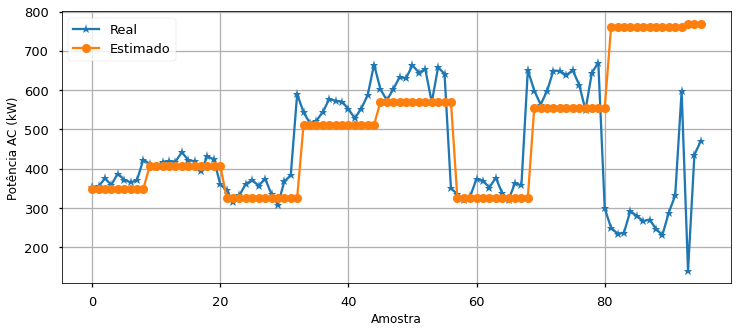

In [139]:
i=1779
j=i+48*2
plt.figure(figsize=(12,5))
plt.plot(range(j-i), np.array(teste_reshape['AC_POWER_FUTURO'][i:j]),'-*' ,range(j-i), previsaoTesteNormalizadoInvertido_LSTM[i:j],'-o')
plt.legend(('Real','Estimado'))
plt.xlabel('Amostra',fontsize=12)
plt.ylabel('Potência AC (kW)',fontsize=12)
plt.savefig(diretorioImagens + '/Desempenho_Teste_Invertido' + nomeModelo + '.png', format='png', bbox_inches='tight')
plt.grid()
plt.show()

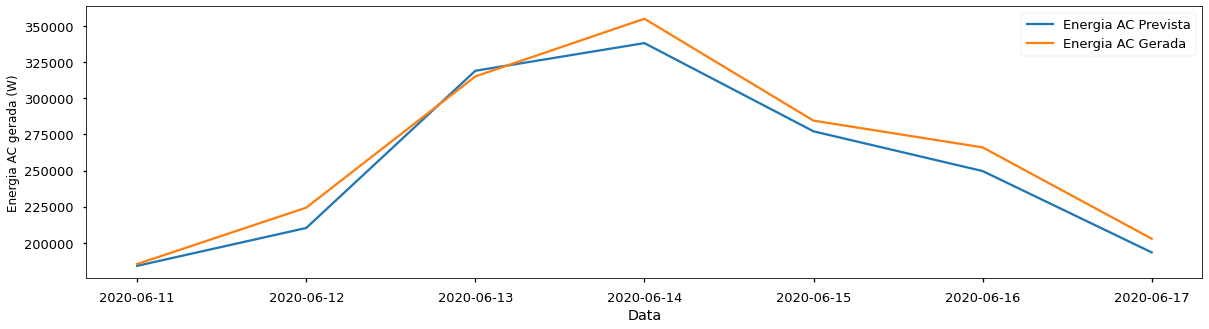

In [140]:
# Previsão da amostra de teste - LSTM (Últimos 10 dias)
previsoesPlot = teste_reshape.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesPlot['AC_POWER_FUTURO'] = previsaoTesteNormalizadoInvertido_LSTM

# Plotar gráfico
previsoesPlot['Data'] = previsoesPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesPlot = previsoesPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesPlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Prevista')

testePlot = teste_reshape.copy()
testePlot['Data'] = testePlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
testePlot = testePlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
testePlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Gerada')

plt.ylabel('Energia AC gerada (W)',fontsize=12)
plt.legend()
plt.show()

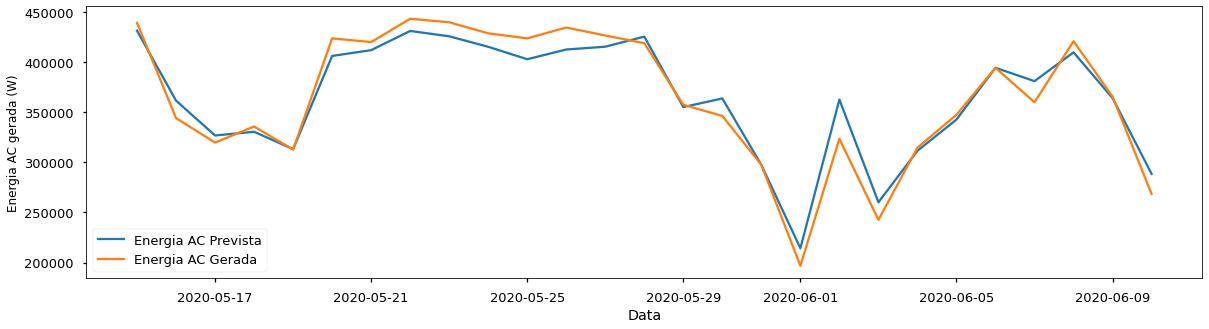

In [141]:
# Previsão da amostra de treino - LSTM (Primeiros 27 dias)
previsoesPlot = treino_reshape.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesPlot['AC_POWER_FUTURO'] = previsaoTreinoNormalizadoInvertido_LSTM

# Plotar gráfico
previsoesPlot['Data'] = previsoesPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesPlot = previsoesPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesPlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Prevista')

treinoPlot = treino_reshape.copy()
treinoPlot['Data'] = treinoPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
treinoPlot = treinoPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
treinoPlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Gerada')

plt.ylabel('Energia AC gerada (W)',fontsize=12)
plt.legend()
plt.show()

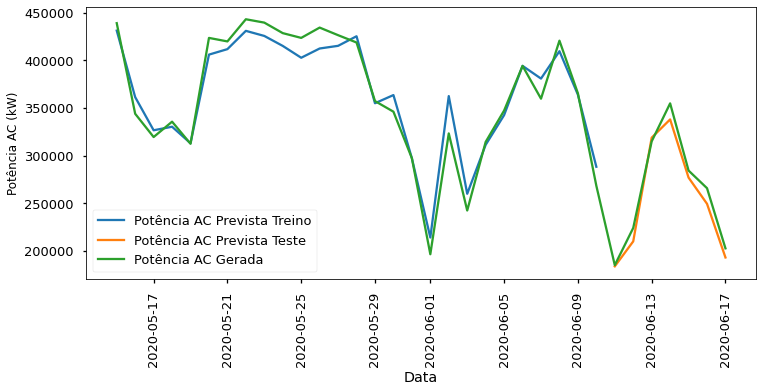

In [142]:
# Previsão da amostra completa - LSTM
# Plotar gráfico previsão treino
previsoesTreinoPlot = treino_reshape.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesTreinoPlot['AC_POWER_FUTURO'] = previsaoTreinoNormalizadoInvertido_LSTM

previsoesTreinoPlot['Data'] = previsoesTreinoPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesTreinoPlot = previsoesTreinoPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesTreinoPlot['AC_POWER_FUTURO'].plot(figsize=(12,5),label='Potência AC Prevista Treino')

# Plotar gráfico previsão teste
previsoesTestePlot = teste_reshape.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesTestePlot['AC_POWER_FUTURO'] = previsaoTesteNormalizadoInvertido_LSTM

previsoesTestePlot['Data'] = previsoesTestePlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesTestePlot = previsoesTestePlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesTestePlot['AC_POWER_FUTURO'].plot(figsize=(12,5),label='Potência AC Prevista Teste')

# Plotar gráfico original
completoPlot = dtGeracaoEnergia.copy()
completoPlot['Data'] = completoPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
completoPlot = completoPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
completoPlot['AC_POWER_FUTURO'].plot(figsize=(12,5),label='Potência AC Gerada')

plt.ylabel('Potência AC (kW)',fontsize=12)
plt.xticks(rotation = 90)
plt.legend()
plt.savefig(diretorioImagens + '/' + nomeModelo + '_' + str(neuroniosLSTM) + '_' + str(batchSizeLSTM) + '_' + str(epocasLSTM) + '_' + str(qtdCamadasLSTM) + '_completa.png', format='png', bbox_inches='tight')
plt.show()

## 7.6 Erro RMSE

In [143]:
# Cálculo do RMSE para amostra teste
testScore_LSTM = math.sqrt(mean_squared_error(np.array(teste_reshape['AC_POWER_FUTURO']), previsaoTesteNormalizadoInvertido_LSTM))
print("O valor do RMSE para a amostra teste é: " + str(testScore_LSTM))

# Cálculo do RMSE para amostra treino
treinoScore_LSTM = math.sqrt(mean_squared_error(np.array(treino_reshape['AC_POWER_FUTURO']), previsaoTreinoNormalizadoInvertido_LSTM))
print("O valor do RMSE para a amostra treino é: " + str(treinoScore_LSTM))

# Cálculo do RMSE para amostra completa
completoScore_LSTM = math.sqrt(mean_squared_error(np.array(completo_reshape['AC_POWER_FUTURO']), previsaoCompletoNormalizadoInvertido_LSTM))
print("O valor do RMSE para a amostra completa é: " + str(completoScore_LSTM))

O valor do RMSE para a amostra teste é: 121.79169663681382
O valor do RMSE para a amostra treino é: 149.08919469177067
O valor do RMSE para a amostra completa é: 143.87961776486222


# 8. Modelagem com LSTM - Window

In [144]:
# Divide uma sequência com múltiplos atributos em duas amostras
def criar_amostra(sequencias, look_back):
    Entrada, saida = list(), list()
    for i in range(len(sequencias)):
        # Olha para trás de acordo com a quantidade de passos desejados
        end_ix = i + look_back
        # Verifica se existem dados para olhar para trás na amostra de entrada
        if end_ix > len(sequencias)-1:
            break
        # Separa a amostra de entrada em "Entrada" e "Saída"
        seq_x = sequencias[i:end_ix, :-1] # Coleta os valores de entrada
        #seq_y = sequencias[end_ix, -1] # Coleta os valores de saída futuros
        seq_y = sequencias[end_ix - 1, -1] # Coleta os valores de saída futuros
        Entrada.append(seq_x)
        saida.append(seq_y)
    return np.array(Entrada), np.array(saida)

In [145]:
dataset_treino_normalizado[0]

array([0.01179685, 0.01076324])

In [146]:
treinoY_normalizado[0]

0.01076324251142325

In [147]:
look_back = 48

treinoX_normalizado, treinoY_normalizado = criar_amostra(dataset_treino_normalizado, look_back)
testeX_normalizado, testeY_normalizado = criar_amostra(dataset_teste_normalizado, look_back)
completoX_normalizado, completoY_normalizado = criar_amostra(dataset_completo_normalizado, look_back)

# Imprimir primeira linha da entrada do dataset de treino
print(treinoX_normalizado[0:3])

# Imprimir primeira linha da saída do dataset de treino (Percebe-se que o primeiro item é o valor futuro da amostra completa)
print("\n", treinoY_normalizado[0:3])

[[[0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.03862096]
  [0.03862096]
  [0.03862096]
  [0.03862096]
  [0.03862096]
  [0.03862096]
  [0.03862096]
  [0.03862096]
  [0.03862096]
  [0.03862096]
  [0.03862096]
  [0.03862096]
  [0.09419283]
  [0.09419283]
  [0.09419283]
  [0.09419283]
  [0.09419283]
  [0.09419283]
  [0.09419283]
  [0.09419283]
  [0.09419283]
  [0.09419283]
  [0.09419283]
  [0.09419283]]

 [[0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01179685]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.01914663]
  [0.019

In [148]:
print(dataset_treino_normalizado[47]) # Última linha da primeira amostra

[0.09419283 0.01771148]


In [149]:
print(dataset_treino_normalizado[48]) # Última linha da segunda amostra

[0.01628666 0.01770665]


In [150]:
# Formato dos dados de treino
print(treinoX_normalizado.shape, treinoY_normalizado.shape)

# Formato dos dados de teste
print(testeX_normalizado.shape, testeY_normalizado.shape)

# Formato dos dados da amostra compelta
print(completoX_normalizado.shape, completoY_normalizado.shape)

(16752, 48, 1) (16752,)
(4319, 48, 1) (4319,)
(21119, 48, 1) (21119,)


In [151]:
# Criando modelo LSTM
# A rede possui camada visível com 1 entrada
# Camada oculta com 64 blocos LSTM ou neurônios
# 1 camada de saída
# Função de ativação sigmoide padrão
# Tamanho de lote (batch size) igual a 32

nomeModelo = 'LSTM_Window' + nomeEntrada

# Coleta o número de atributos da amostra criada
n_atributos = treinoX_normalizado.shape[2]

neuroniosLSTM = 64
batchSizeLSTM = 32
epocasLSTM = 200
qtdCamadasLSTM = 1

reset_random_seeds()

model_LSTM_Window = Sequential()
model_LSTM_Window.add(layers.LSTM(neuroniosLSTM, activation='sigmoid', input_shape = (look_back, n_atributos)))
model_LSTM_Window.add(layers.Dense(1)) # camada de saída
model_LSTM_Window.compile(loss = "mean_squared_error", optimizer = 'adam')
model_LSTM_Window.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [152]:
# Reduz o platô, ou seja, percebe se o treinamento entrou em um ponto de cela
rlronp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Interrompe o treinamento quando não calcular nenhum progresso na validação definida para várias épocsa
early_stopping_LSTM = EarlyStopping(monitor='val_loss', mode='min', patience = 10, verbose=1, restore_best_weights = True)

# Checkpoint, salva os pontos de verificação do modelo em intervalos regulares durante o treinamento, por padrão no fim de cada época, além disso, com save_best_only, salva somente o melhor modelo
checkpoint_LSTM = ModelCheckpoint(diretorioModelos + '/' + nomeModelo + '_' + str(neuroniosLSTM) + '_' + str(batchSizeLSTM) + '_' + str(epocasLSTM) + '_' + str(qtdCamadasLSTM) + '.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [153]:
reset_random_seeds()

# Fit do modelo
# validation_split = 0,1 - seleciona 10% dos dados de treinamento para realizar a validação durante o treino, isto é necessário para avaliar o desempenho do modelo com dados novos, visto que 10%
# dos dados de treinamento não serão utilizados no treino mas sim para verificar se estão sendo previstos adequadamente, auxilia a perceber se o modelo está causando overfitting
# isto é utilizado também para a função save_best_only, onde somente o modelo com melhor desempenho será salvo
historico_LSTM_Window = model_LSTM_Window.fit(treinoX_normalizado, treinoY_normalizado, epochs = epocasLSTM, batch_size = batchSizeLSTM, verbose = 2, validation_split = 0.15,
                        callbacks = [rlronp, early_stopping_LSTM, checkpoint_LSTM])

# Salvar modelo
model_LSTM_Window.save(diretorioModelos + '/' + nomeModelo + '_' + str(neuroniosLSTM) + '_' + str(batchSizeLSTM) + '_' + str(epocasLSTM) + '_' + str(qtdCamadasLSTM) + '.h5')

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.01530, saving model to /content/drive/MyDrive/TCC/Modelos/LSTM_Window_64_32_200_1.h5
445/445 - 12s - loss: 0.0550 - val_loss: 0.0153 - lr: 0.0010 - 12s/epoch - 27ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.01530
445/445 - 10s - loss: 0.0115 - val_loss: 0.0155 - lr: 0.0010 - 10s/epoch - 23ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.01530
445/445 - 10s - loss: 0.0112 - val_loss: 0.0153 - lr: 0.0010 - 10s/epoch - 23ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.01530 to 0.01528, saving model to /content/drive/MyDrive/TCC/Modelos/LSTM_Window_64_32_200_1.h5
445/445 - 10s - loss: 0.0110 - val_loss: 0.0153 - lr: 5.0000e-04 - 10s/epoch - 23ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.01528
445/445 - 10s - loss: 0.0112 - val_loss: 0.0162 - lr: 5.0000e-04 - 10s/epoch - 23ms/step
Epoch 6/200

Epoch 6: val_loss did not improve from 0.01528
445/445 - 10s - loss: 0.0110 - val_loss: 0.01

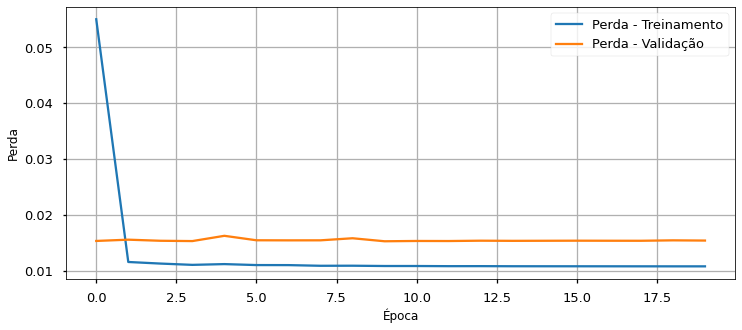

In [154]:
plt.figure(figsize=(12,5))
plt.plot(historico_LSTM_Window.history['loss'], label = 'Perda - Treinamento')
plt.plot(historico_LSTM_Window.history['val_loss'], label = 'Perda - Validação')
plt.grid()
plt.xlabel('Época',fontsize=12)
plt.ylabel('Perda',fontsize=12)
plt.legend()
plt.savefig(diretorioImagens + '/Perdas_' + nomeModelo + '_' + str(neuroniosLSTM) + '_' + str(batchSizeLSTM) + '_' + str(epocasLSTM) + '_' + str(qtdCamadasLSTM) + '.png', format='png', bbox_inches='tight')

## 8.1 Previsões

In [155]:
# Previsão da amostra de teste - LSTM
previsaoTesteNormalizado_LSTM_Window = model_LSTM_Window.predict(testeX_normalizado)

# Previsão da amostra de treino - LSTM
previsaoTreinoNormalizado_LSTM_Window = model_LSTM_Window.predict(treinoX_normalizado)

# Previsão da amostra completa - LSTM
previsaoCompletoNormalizado_LSTM_Window = model_LSTM_Window.predict(completoX_normalizado)

In [156]:
# Formato dos dados previstos para teste
print(previsaoTesteNormalizado_LSTM_Window.shape, teste.shape)

# Formato dos dados previstos para treino
print(previsaoTreinoNormalizado_LSTM_Window.shape, treino.shape)

# Formato dos dados previstos para a amostra completa
print(previsaoCompletoNormalizado_LSTM_Window.shape, dtGeracaoEnergia.shape)

(4319, 1) (4367, 9)
(16752, 1) (16800, 9)
(21119, 1) (21167, 9)


## 8.2 Erro MSE

In [157]:
desempenho_treino = mean_squared_error(treinoY_normalizado, previsaoTreinoNormalizado_LSTM_Window)
print(f'Desempenho do treinamento: {desempenho_treino} MSE')

desempenho_teste = mean_squared_error(testeY_normalizado, previsaoTesteNormalizado_LSTM_Window)
print(f'Desempenho do teste: {desempenho_teste} MSE')

desempenho_completo = mean_squared_error(completoY_normalizado, previsaoCompletoNormalizado_LSTM_Window)
print(f'Desempenho da amostra completa: {desempenho_completo} MSE')

Desempenho do treinamento: 0.011527430865204908 MSE
Desempenho do teste: 0.008458656608738483 MSE
Desempenho da amostra completa: 0.01087368920901611 MSE


In [158]:
desempenho_treino_rmse = math.sqrt(mean_squared_error(treinoY_normalizado, previsaoTreinoNormalizado_LSTM_Window))
print(f'Desempenho do treinamento: {desempenho_treino_rmse} RMSE')

desempenho_teste_rmse = math.sqrt(mean_squared_error(testeY_normalizado, previsaoTesteNormalizado_LSTM_Window))
print(f'Desempenho do teste: {desempenho_teste_rmse} RMSE')

desempenho_completo_rmse = math.sqrt(mean_squared_error(completoY_normalizado, previsaoCompletoNormalizado_LSTM_Window))
print(f'Desempenho da amostra completa: {desempenho_completo_rmse} RMSE')

Desempenho do treinamento: 0.10736587383896667 RMSE
Desempenho do teste: 0.09197095524532994 RMSE
Desempenho da amostra completa: 0.10427698312195319 RMSE


In [159]:
testeY_normalizado[0]

0.05084772104814171

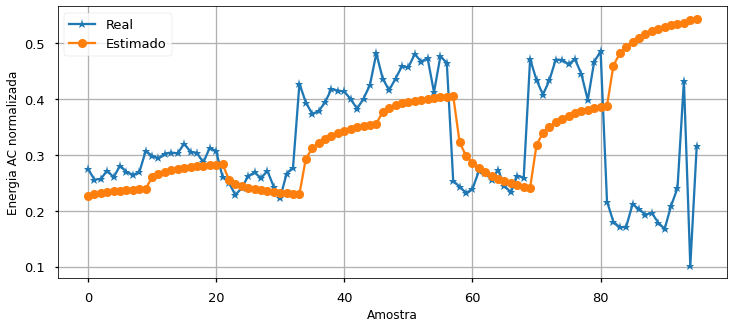

In [160]:
i=1779 - look_back
j=i+48*2
plt.figure(figsize=(12,5))
plt.plot(range(j-i), testeY_normalizado[i:j],'-*' ,range(j-i), previsaoTesteNormalizado_LSTM_Window[i:j],'-o')
plt.legend(('Real','Estimado'))
plt.xlabel('Amostra',fontsize=12)
plt.ylabel('Energia AC normalizada',fontsize=12)
plt.savefig(diretorioImagens + '/Desempenho_Teste_' + nomeModelo + '.png', format='png', bbox_inches='tight')
plt.grid()
plt.show()

## 8.3 Preparando amostras reais

Para gerar o gráfico posteriormente será necessário remover uma linha de dado das amostras reais.

In [161]:
teste

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,HOUR,AC_POWER,AC_POWER_FUTURO
2592,2020-06-11 06:00:00,81aHJ1q11NBPMrL,24.265365,23.726226,0.004264,11,6,0.700000,0.685714
2593,2020-06-11 06:00:00,9kRcWv60rDACzjR,24.265365,23.726226,0.004264,11,6,0.685714,0.614286
2594,2020-06-11 06:00:00,LYwnQax7tkwH5Cb,24.265365,23.726226,0.004264,11,6,0.614286,0.000000
2595,2020-06-11 06:00:00,LlT2YUhhzqhg5Sw,24.265365,23.726226,0.004264,11,6,0.000000,0.573333
2596,2020-06-11 06:00:00,PeE6FRyGXUgsRhN,24.265365,23.726226,0.004264,11,6,0.573333,1.366667
...,...,...,...,...,...,...,...,...,...
21162,2020-06-17 17:45:00,WcxssY2VbP4hApt,26.091664,27.235657,0.065480,17,17,97.046667,96.620000
21163,2020-06-17 17:45:00,oZZkBaNadn6DNKz,26.091664,27.235657,0.065480,17,17,96.620000,94.700000
21164,2020-06-17 17:45:00,q49J1IKaHRwDQnt,26.091664,27.235657,0.065480,17,17,94.700000,89.680000
21165,2020-06-17 17:45:00,rrq4fwE8jgrTyWY,26.091664,27.235657,0.065480,17,17,89.680000,96.693333


In [162]:
# Removendo linhas da amostra real
teste_reshape = teste.copy()
treino_reshape = treino.copy()
completo_reshape = dtGeracaoEnergia.copy()

for i in range(look_back - 1):
    teste_reshape = teste_reshape.drop([teste.index[i]])
    treino_reshape = treino_reshape.drop([treino.index[i]])
    completo_reshape = completo_reshape.drop([dtGeracaoEnergia.index[i]])

teste_reshape = teste_reshape.drop([teste.index[-1]])
treino_reshape = treino_reshape.drop([treino.index[-1]])
completo_reshape = completo_reshape.drop([dtGeracaoEnergia.index[-1]])

In [163]:
# Invertendo normalização das amostras reais para comparar e verificar se as data tables foram corretamente filtradas
scale = MinMaxScaler()
scale.min_, scale.scale_ = scaler_com_dados_treino.min_[treinoX_normalizado.shape[2]], scaler_com_dados_treino.scale_[treinoX_normalizado.shape[2]]

# Para amostra real teste
testeY_invertido =  scale.inverse_transform(testeY_normalizado.reshape(-1,1))

# Para amostra real teste
treinoY_invertido =  scale.inverse_transform(treinoY_normalizado.reshape(-1,1))

# Para amostra real teste
completoY_invertido =  scale.inverse_transform(completoY_normalizado.reshape(-1,1))

In [164]:
# Amostra real não normalizada utilizada para comparar com os dados previstos
print(testeY_invertido)

[[70.10714286]
 [69.19285714]
 [66.2       ]
 ...
 [94.7       ]
 [89.68      ]
 [96.69333333]]


In [165]:
teste_reshape

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,HOUR,AC_POWER,AC_POWER_FUTURO
2639,2020-06-11 06:45:00,xoJJ8DcxJEcupym,24.227979,23.938855,0.022495,11,6,33.235714,70.107143
2640,2020-06-11 18:00:00,81aHJ1q11NBPMrL,26.725963,26.888934,0.046955,11,18,70.107143,69.192857
2641,2020-06-11 18:00:00,9kRcWv60rDACzjR,26.725963,26.888934,0.046955,11,18,69.192857,66.200000
2642,2020-06-11 18:00:00,LYwnQax7tkwH5Cb,26.725963,26.888934,0.046955,11,18,66.200000,67.850000
2643,2020-06-11 18:00:00,LlT2YUhhzqhg5Sw,26.725963,26.888934,0.046955,11,18,67.850000,69.586667
...,...,...,...,...,...,...,...,...,...
21161,2020-06-17 17:45:00,V94E5Ben1TlhnDV,26.091664,27.235657,0.065480,17,17,95.106667,97.046667
21162,2020-06-17 17:45:00,WcxssY2VbP4hApt,26.091664,27.235657,0.065480,17,17,97.046667,96.620000
21163,2020-06-17 17:45:00,oZZkBaNadn6DNKz,26.091664,27.235657,0.065480,17,17,96.620000,94.700000
21164,2020-06-17 17:45:00,q49J1IKaHRwDQnt,26.091664,27.235657,0.065480,17,17,94.700000,89.680000


In [166]:
# Amostra real não normalizada utilizada para comparar com os dados previstos
print(treinoY_invertido)

[[24.42      ]
 [24.41333333]
 [23.56      ]
 ...
 [13.6       ]
 [14.47142857]
 [13.55714286]]


In [167]:
treino_reshape

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,HOUR,AC_POWER,AC_POWER_FUTURO
47,2020-05-15 06:45:00,xoJJ8DcxJEcupym,25.048245,25.746662,0.103496,15,6,144.166667,24.420000
48,2020-05-15 18:00:00,81aHJ1q11NBPMrL,34.367762,33.148010,0.017895,15,18,24.420000,24.413333
49,2020-05-15 18:00:00,9kRcWv60rDACzjR,34.367762,33.148010,0.017895,15,18,24.413333,23.560000
50,2020-05-15 18:00:00,LYwnQax7tkwH5Cb,34.367762,33.148010,0.017895,15,18,23.560000,23.873333
51,2020-05-15 18:00:00,LlT2YUhhzqhg5Sw,34.367762,33.148010,0.017895,15,18,23.873333,23.140000
...,...,...,...,...,...,...,...,...,...
17466,2020-06-10 17:45:00,WcxssY2VbP4hApt,27.759774,25.464606,0.007683,10,17,14.264286,13.207143
17467,2020-06-10 17:45:00,oZZkBaNadn6DNKz,27.759774,25.464606,0.007683,10,17,13.207143,14.257143
17468,2020-06-10 17:45:00,q49J1IKaHRwDQnt,27.759774,25.464606,0.007683,10,17,14.257143,13.600000
17469,2020-06-10 17:45:00,rrq4fwE8jgrTyWY,27.759774,25.464606,0.007683,10,17,13.600000,14.471429


In [168]:
# Amostra real não normalizada utilizada para comparar com os dados previstos
print(completoY_invertido)

[[24.42      ]
 [24.41333333]
 [23.56      ]
 ...
 [94.7       ]
 [89.68      ]
 [96.69333333]]


In [169]:
completo_reshape

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,HOUR,AC_POWER,AC_POWER_FUTURO
47,2020-05-15 06:45:00,xoJJ8DcxJEcupym,25.048245,25.746662,0.103496,15,6,144.166667,24.420000
48,2020-05-15 18:00:00,81aHJ1q11NBPMrL,34.367762,33.148010,0.017895,15,18,24.420000,24.413333
49,2020-05-15 18:00:00,9kRcWv60rDACzjR,34.367762,33.148010,0.017895,15,18,24.413333,23.560000
50,2020-05-15 18:00:00,LYwnQax7tkwH5Cb,34.367762,33.148010,0.017895,15,18,23.560000,23.873333
51,2020-05-15 18:00:00,LlT2YUhhzqhg5Sw,34.367762,33.148010,0.017895,15,18,23.873333,23.140000
...,...,...,...,...,...,...,...,...,...
21161,2020-06-17 17:45:00,V94E5Ben1TlhnDV,26.091664,27.235657,0.065480,17,17,95.106667,97.046667
21162,2020-06-17 17:45:00,WcxssY2VbP4hApt,26.091664,27.235657,0.065480,17,17,97.046667,96.620000
21163,2020-06-17 17:45:00,oZZkBaNadn6DNKz,26.091664,27.235657,0.065480,17,17,96.620000,94.700000
21164,2020-06-17 17:45:00,q49J1IKaHRwDQnt,26.091664,27.235657,0.065480,17,17,94.700000,89.680000


In [170]:
# Comparação entre os formatos da previsão e dos dados para plotar o gráfico real
print(previsaoTesteNormalizado_LSTM_Window.shape, teste_reshape.shape)

# Comparação entre os formatos da previsão e dos dados para plotar o gráfico real
print(previsaoTreinoNormalizado_LSTM_Window.shape, treino_reshape.shape)

# Comparação entre os formatos da previsão e dos dados para plotar o gráfico real
print(previsaoCompletoNormalizado_LSTM_Window.shape, completo_reshape.shape)

(4319, 1) (4319, 9)
(16752, 1) (16752, 9)
(21119, 1) (21119, 9)


## 8.4 Invertendo Normalização

In [171]:
# Imprime valores minímos e máximos
# min_ = min - X.min(axis=0) * self.scale_
# scale_ = (max - min) / (X.max(axis=0) - X.min(axis=0))
# data_min_ = valor mínimo na amostra
# data_max_ = valor máximo na amostra
scaler_com_dados_treino.min_, scaler_com_dados_treino.scale_, scaler_com_dados_treino.data_min_, scaler_com_dados_treino.data_max_

(array([0., 0.]),
 array([9.10111853e-01, 7.25285884e-04]),
 array([0., 0.]),
 array([1.09876604e+00, 1.37876667e+03]))

In [172]:
# Invertendo normalização para interpretação dos resultados
scale = MinMaxScaler()
scale.min_, scale.scale_ = scaler_com_dados_treino.min_[treinoX_normalizado.shape[2]], scaler_com_dados_treino.scale_[treinoX_normalizado.shape[2]]

# Para amostra de teste
previsaoTesteNormalizadoInvertido_LSTM_Window = scale.inverse_transform(previsaoTesteNormalizado_LSTM_Window) # Inverte normalização para os valores previstos de teste

# Para amostra de treino
previsaoTreinoNormalizadoInvertido_LSTM_Window = scale.inverse_transform(previsaoTreinoNormalizado_LSTM_Window)

# Para amostra completa
previsaoCompletoNormalizadoInvertido_LSTM_Window = scale.inverse_transform(previsaoCompletoNormalizado_LSTM_Window)

## 8.5 Resultado das Previsões

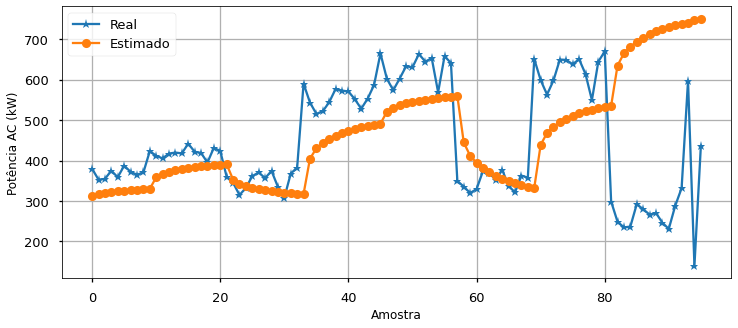

In [173]:
i=1779 - look_back
j=i+48*2
plt.figure(figsize=(12,5))
plt.plot(range(j-i), np.array(teste_reshape['AC_POWER_FUTURO'][i:j]),'-*' ,range(j-i), previsaoTesteNormalizadoInvertido_LSTM_Window[i:j],'-o')
plt.legend(('Real','Estimado'))
plt.xlabel('Amostra',fontsize=12)
plt.ylabel('Potência AC (kW)',fontsize=12)
plt.savefig(diretorioImagens + '/Desempenho_Teste_Invertido' + nomeModelo + '.png', format='png', bbox_inches='tight')
plt.grid()
plt.show()

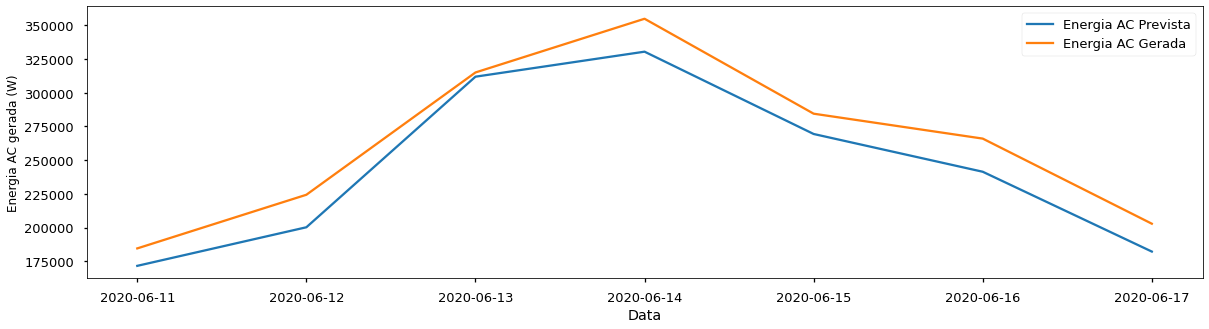

In [174]:
# Previsão da amostra de teste - LSTM (Últimos 10 dias)
previsoesPlot = teste_reshape.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesPlot['AC_POWER_FUTURO'] = previsaoTesteNormalizadoInvertido_LSTM_Window

# Plotar gráfico
previsoesPlot['Data'] = previsoesPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesPlot = previsoesPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesPlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Prevista')

testePlot = teste_reshape.copy()
testePlot['Data'] = testePlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
testePlot = testePlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
testePlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Gerada')

plt.ylabel('Energia AC gerada (W)',fontsize=12)
plt.legend()
plt.show()

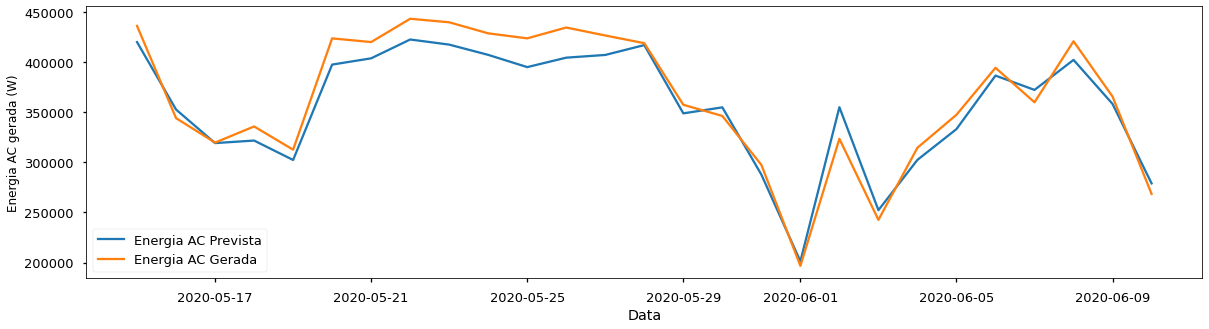

In [175]:
# Previsão da amostra de treino - LSTM (Primeiros 27 dias)
previsoesPlot = treino_reshape.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesPlot['AC_POWER_FUTURO'] = previsaoTreinoNormalizadoInvertido_LSTM_Window

# Plotar gráfico
previsoesPlot['Data'] = previsoesPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesPlot = previsoesPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesPlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Prevista')

treinoPlot = treino_reshape.copy()
treinoPlot['Data'] = treinoPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
treinoPlot = treinoPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
treinoPlot['AC_POWER_FUTURO'].plot(figsize=(20,5),label='Energia AC Gerada')

plt.ylabel('Energia AC gerada (W)',fontsize=12)
plt.legend()
plt.show()

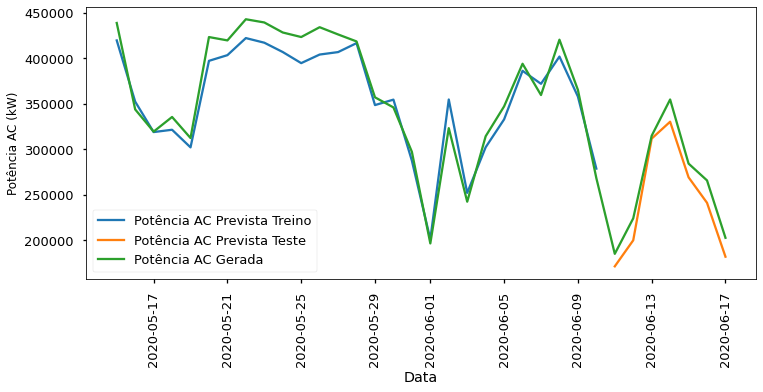

In [176]:
# Previsão da amostra completa - LSTM
# Plotar gráfico previsão treino
previsoesTreinoPlot = treino_reshape.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesTreinoPlot['AC_POWER_FUTURO'] = previsaoTreinoNormalizadoInvertido_LSTM_Window

previsoesTreinoPlot['Data'] = previsoesTreinoPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesTreinoPlot = previsoesTreinoPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesTreinoPlot['AC_POWER_FUTURO'].plot(figsize=(12,5),label='Potência AC Prevista Treino')

# Plotar gráfico previsão teste
previsoesTestePlot = teste_reshape.drop(columns=['IRRADIATION', 'SOURCE_KEY', 'AC_POWER'])
previsoesTestePlot['AC_POWER_FUTURO'] = previsaoTesteNormalizadoInvertido_LSTM_Window

previsoesTestePlot['Data'] = previsoesTestePlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
previsoesTestePlot = previsoesTestePlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
previsoesTestePlot['AC_POWER_FUTURO'].plot(figsize=(12,5),label='Potência AC Prevista Teste')

# Plotar gráfico original
completoPlot = dtGeracaoEnergia.copy()
completoPlot['Data'] = completoPlot['DATE_TIME'].dt.date # Cria uma coluna com as datas da amostra
completoPlot = completoPlot.groupby('Data').sum() # Soma a energia gerada em cada horário durante todo o dia para cada um dos dias
completoPlot['AC_POWER_FUTURO'].plot(figsize=(12,5),label='Potência AC Gerada')

plt.ylabel('Potência AC (kW)',fontsize=12)
plt.xticks(rotation = 90)
plt.legend()
plt.savefig(diretorioImagens + '/' + nomeModelo + '_' + str(neuroniosLSTM) + '_' + str(batchSizeLSTM) + '_' + str(epocasLSTM) + '_' + str(qtdCamadasLSTM) + '_completa.png', format='png', bbox_inches='tight')
plt.show()

## 8.6 Erro RMSE

In [177]:
# Cálculo do RMSE para amostra teste
testScore_LSTM = math.sqrt(mean_squared_error(np.array(teste_reshape['AC_POWER_FUTURO']), previsaoTesteNormalizadoInvertido_LSTM_Window))
print("O valor do RMSE para a amostra teste é: " + str(testScore_LSTM))

# Cálculo do RMSE para amostra treino
treinoScore_LSTM = math.sqrt(mean_squared_error(np.array(treino_reshape['AC_POWER_FUTURO']), previsaoTreinoNormalizadoInvertido_LSTM_Window))
print("O valor do RMSE para a amostra treino é: " + str(treinoScore_LSTM))

# Cálculo do RMSE para amostra completa
completoScore_LSTM = math.sqrt(mean_squared_error(np.array(completo_reshape['AC_POWER_FUTURO']), previsaoCompletoNormalizadoInvertido_LSTM_Window))
print("O valor do RMSE para a amostra completa é: " + str(completoScore_LSTM))

O valor do RMSE para a amostra teste é: 126.8064903711032
O valor do RMSE para a amostra treino é: 148.03248968574343
O valor do RMSE para a amostra completa é: 143.77363035596198
